In [1]:
from Bio import SeqIO
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from matplotlib.lines import Line2D
import numpy as np
from numpy import average, median
from scipy.stats import mannwhitneyu as mwu
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import euclidean
from scipy import stats
from os import path
import hashlib
from Bio import SeqIO
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import optimize
from Bio.KEGG import REST
from Bio.KEGG import Enzyme
from collections import Counter
from itertools import chain

%matplotlib inline

## Process reads
### Merge files from two separate MiSeq lanes
Concatenate files from two run, e.g., for samples AS101, concatenate file R1 form the first and run to R1 from second sequencing run.

In [ ]:
!mkdir concat

for f in glob.glob('raw_reads/*.fastq.gz'):
    filename = f.split('/')[-1].replace('.gz','')
    f2 = 'raw_reads/core5_run2/%s.gz' % filename
    concat = 'concat/%s' % filename
    if path.exists(f2):
        !zcat $f $f2 > $concat
    else:
        !zcat $f > $concat

### Quality trim reads at windows with PHRED score < 30 with Trimmomatic
#### Install Trimmomatic:  
`conda install -c bioconda trimmomatic`
  
#### Run Trimmomatic:

In [ ]:
!mkdir trimmed_reads
!mkdir trimmed_reads_singletons
!mkdir trimmomatic_stats


with open('trimmomatic_stats/trimmomatic_log.txt','wt') as log:
    for R1 in glob.glob('concat/*_R1_*.fastq'):
        smpl = R1.split('/')[-1].split('_')[0]
        R2 = R1.replace('_R1_','_R2_')
        f_paired = R1.replace('concat','trimmed_reads')
        r_paired = R2.replace('concat','trimmed_reads')
        f_single = R1.replace('concat','trimmed_reads_singletons')
        r_single= R2.replace('concat','trimmed_reads_singletons')

        lines = !trimmomatic PE -phred33 \
                    $R1 \
                    $R2 \
                    $f_paired \
                    $f_single \
                    $r_paired \
                    $r_single \
                    ILLUMINACLIP:None:2:30:10 \
                    LEADING:3 \
                    TRAILING:3 \
                    SLIDINGWINDOW:4:15 \
                    MINLEN:150
        for l in lines:
            log.write(l+'\n')

#### Summary plots

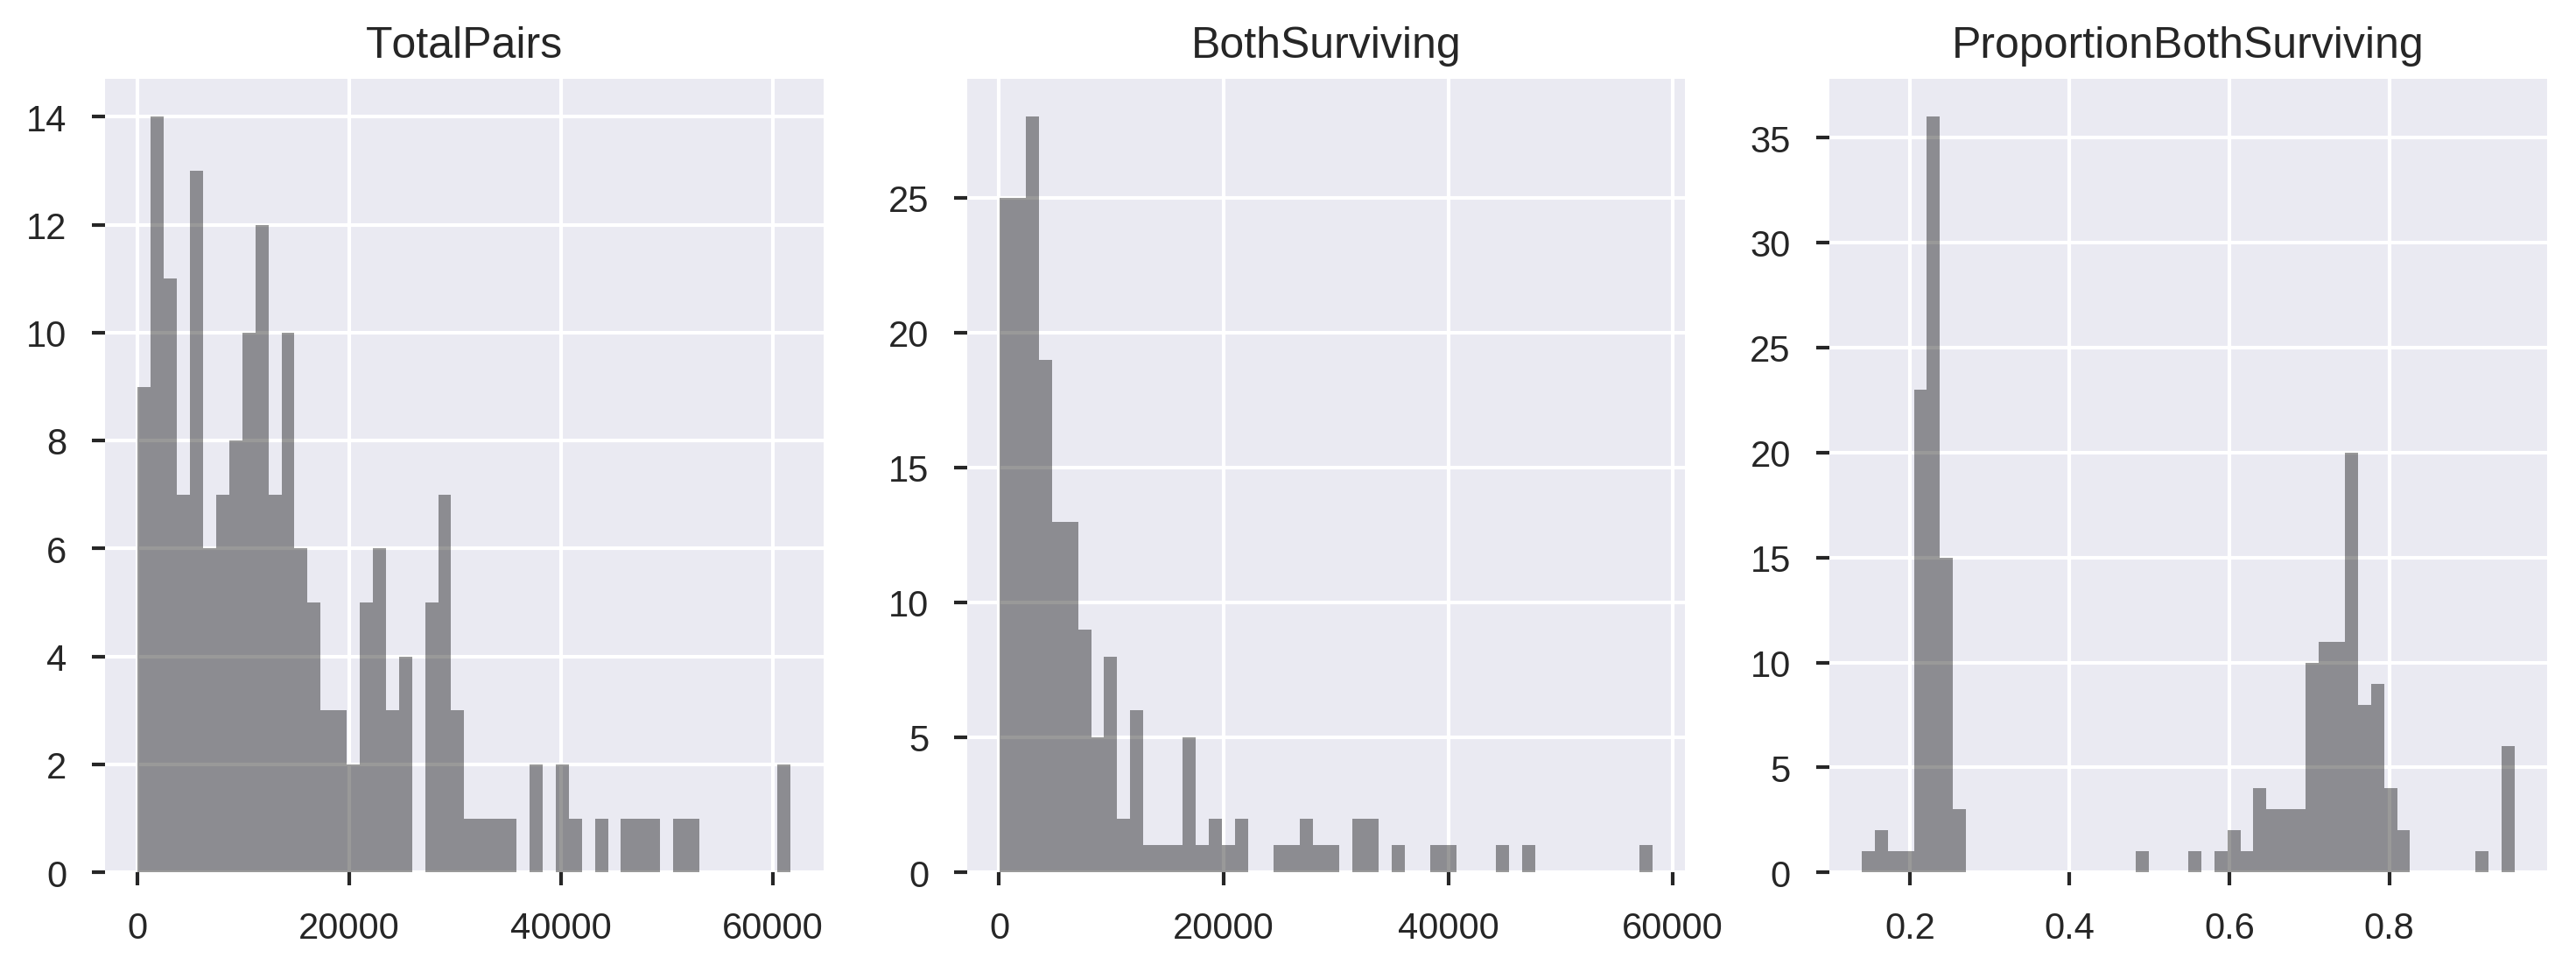

In [94]:
logs = open('trimmomatic_stats/trimmomatic_log.txt','r').read().split('TrimmomaticPE: Started with arguments:')[1:]

df = pd.DataFrame(columns = ['TotalPairs','BothSurviving'])

for l in logs:
    lines = l.splitlines()[1:]
    smpl = lines[0].split()[2].split('/')[-1].split('_')[0]
    try:
        total = int(lines[-3].split(' ')[3])
        survive = int(lines[-3].split(' ')[6])
    except:
        total = int(lines[-2].split(' ')[3])
        survive = int(lines[-2].split(' ')[6])
    df.loc[smpl] = [total,survive]
    
df['Proportion'] = df.BothSurviving / df.TotalPairs
df.to_csv('trimmomatic_stats/summary.tsv',sep='\t')

fig, axes = plt.subplots(ncols=3,figsize=(12,4),dpi=300)

ax = axes[0]
sns.distplot(df.loc[df.TotalPairs < 65000].TotalPairs.tolist(),ax=ax,color='black',kde=False,bins=50)
ax.set_title('TotalPairs')
ax = axes[1]
sns.distplot(df.loc[df.TotalPairs < 65000].BothSurviving.tolist(),ax=ax,color='black',kde=False,bins=50)
ax.set_title('BothSurviving')
ax = axes[2]
sns.distplot(df.loc[df.TotalPairs < 65000].Proportion.tolist(), ax=ax,color='black',kde=False,bins=50)
a = ax.set_title('ProportionBothSurviving')

#### Filter files
If there are less than 4000 read pairs, trash sample. If there are over 40,000 read pairs, downsample to 40,000.

In [ ]:
for R1 in glob.glob('trimmed_reads/*_R1_001.fastq'):
    R2 = R1.replace('_R1_','_R2_')
    if len(open(R1,'r').readlines()) < 4000:
        !rm $R1
        !rm $R2
    elif len(open(R1,'r').readlines()) > 40000:
        records = list(SeqIO.parse(R1,'fastq'))
        SeqIO.write(records[:10000],R1,'fastq')
        records = list(SeqIO.parse(R2,'fastq'))
        SeqIO.write(records[:10000],R2,'fastq')

## Metadata
### Add formal location codes and corrected species names

In [2]:
metadata = pd.read_csv('fish_samples_metadata.tsv',index_col=0, sep='\t')

def get_loc_code(string):
    locations = {'AgmonHula':'J.4',
                 'AsiCemetery':'A',
                 'BaniasFall':'H.0.5',
                 'BaniasReserveDown':'H.0.2',
                 'BaniasReserveUp':'H.0.1',
                 'GomeJunction':'J.3',
                 'HuliotSnirXJordan':'J.2',
                 'InsideKtzinim':'H.1',
                 'NabiYuda':'H.0.6',
                 'SnirDagAlHadanUpStrerm':'S.2',
                 'SnirHydrometricMaayanBaruch':'S.1',
                 'SnirYatedotDownstrerm':'S.3',
                 'StreemNextToKtzinim':'H.0.4',
                 'TelSaharonDown':'T.1',
                 'TelSaharonSpring':'T.2',
                 'lehavotHabashan':'J.1'}
    try:
        return locations[string]
    except:
        return 'NTC'

metadata['Sampling site'] = metadata.Location.apply(get_loc_code)
metadata.to_csv('fish_samples_metadata_loc_code.tsv',sep='\t')

metadata = pd.read_csv('fish_samples_metadata_loc_code.tsv',index_col=0,sep='\t')
metadata = metadata.replace(to_replace='Nemacheilus dori', value='Oxynoemacheilus insignis')
metadata = metadata.replace(to_replace='Nemacheilus jordanicus', value='Oxynoemacheilus insignis')
metadata = metadata.replace(to_replace='Mugil cephalus', value='Mugil')
metadata = metadata.replace(to_replace='Barbus canis', value='Carasobarbus canis')
metadata = metadata.replace(to_replace='Tilapia zillii', value='Coptodon zillii')
metadata = metadata.replace(to_replace='Garra rufa', value='Garra jordanica')

metadata['Stream'] = metadata['Sampling site'].str[0]

def fix_swab(string):
    if string == 'swab':
        return 'Swab'
    return string
    
metadata['type'] = metadata['type'].apply(fix_swab)

interupted = ['S.3','H.0.6','J.3']

def get_status(string):
    if string in interupted:
        return 'interrupted'
    return 'pristine'

metadata['Status'] = metadata['Sampling site'].apply(get_status)

metadata.to_csv('fish_samples_metadata_loc_code_correct_sp.tsv',sep='\t')
metadata

BarcodeSequence LinkerPrimerSequence                           SP  \
#SampleID                                                                     
AS208                  AA                   AA                   Garra nana   
AS202                  AA                   AA              Coptodon zillii   
AS203                  AA                   AA              Coptodon zillii   
AS204                  AA                   AA              Coptodon zillii   
AS205                  AA                   AA              Coptodon zillii   
AS207                  AA                   AA     Pseudophoxinus kervillei   
AS206                  AA                   AA        Acanthobrama lissneri   
AS200                  AA                   AA                        Water   
AS75                   AA                   AA                           OH   
AS89                   AA                   AA              Coptodon zillii   
AS90                   AA                   AA              Coptodon zillii   
AS91                   AA                   AA              Coptodon zillii   
AS92                   AA                   AA              Coptodon zillii   
AS93                   AA                   AA              Coptodon zillii   
AS82                   AA                   AA  Astatotilapia flaviijosephi   
AS83                   AA                   AA  Astatotilapia flaviijosephi   
AS84                   AA                   AA  Astatotilapia flaviijosephi   
AS74                   AA                   AA             Gambusia affinis   
AS79                   AA                   AA                        Mugil   
AS80                   AA                   AA                        Mugil   
AS81                   AA                   AA                        Mugil   
AS85                   AA                   AA      Sarotherodon  galilaeus   
AS86                   AA                   AA      Sarotherodon  galilaeus   
AS87                   AA                   AA      Sarotherodon  galilaeus   
AS88                   AA                   AA      Sarotherodon  galilaeus   
AS76                   AA                   AA                           IH   
AS77                   AA                   AA                           IH   
AS78                   AA                   AA                           IH   
AS96BC16               AA                   AA                        Water   
AS98                   AA                   AA            Capoeta damascina   
...                   ...                  ...                          ...   
AS123                  AA                   AA            Capoeta damascina   
AS124                  AA                   AA            Capoeta damascina   
AS125                  AA                   AA            Capoeta damascina   
AS119                  AA                   AA     Oxynoemacheilus insignis   
AS120                  AA                   AA     Oxynoemacheilus insignis   
AS121                  AA                   AA     Oxynoemacheilus insignis   
AS118BC19              AA                   AA                        Water   
AS58                   AA                   AA             Gambusia affinis   
AS59                   AA                   AA             Gambusia affinis   
AS60                   AA                   AA             Gambusia affinis   
AS61                   AA                   AA             Gambusia affinis   
AS62                   AA                   AA             Gambusia affinis   
AS94BC14               AA                   AA                        Water   
AS70                   AA                   AA                           OH   
AS71                   AA                   AA                           OH   
AS72                   AA                   AA                           OH   
AS73                   AA                   AA                           OH   
AS68                   AA                   AA              

In [6]:
cm = sns.light_palette("green", as_cmap=True)
sampling_summary = pd.pivot_table(metadata.loc[metadata['type'] == 'Swab'].sort_values(['Basin','Stream','Sampling site']),
                                  index=["family_or_tribe","SP"],
                                  columns=['Basin',"Sampling site"],
                                  aggfunc={'Sampling site':np.count_nonzero},fill_value=0)
sampling_summary.style.background_gradient(cmap=cm).to_excel('Tables/sampling_summary.xlsx')
sampling_summary.style.background_gradient(cmap=cm)

## DADA2

In [ ]:
%%R
# I had to reinstall dplyr with install.packages(dplyr)
library(Matrix);
library(dada2);
# AS160 was huge and deleted
path <- "~/fish/trimmed_reads" # CHANGE ME to the directory containing the fastq files after unzipping.
# Forward and reverse fastq filenames have format: SAMPLENAME_R1_001.fastq and SAMPLENAME_R2_001.fastq
fnFs <- sort(list.files(path, pattern="_R1_001.fastq", full.names = TRUE))
fnRs <- sort(list.files(path, pattern="_R2_001.fastq", full.names = TRUE))
# Extract sample names, assuming filenames have format: SAMPLENAME_XXX.fastq
sample.names <- sapply(strsplit(basename(fnFs), "_"), `[`, 1)
# Place filtered files in filtered/ subdirectory
filtFs <- file.path(path, "filtered", paste0(sample.names, "_F_filt.fastq.gz"))
filtRs <- file.path(path, "filtered", paste0(sample.names, "_R_filt.fastq.gz"))                                                        
out <- filterAndTrim(fnFs, filtFs, fnRs, filtRs, truncLen=c(150,150),
              maxN=0, maxEE=c(2,2), truncQ=10, rm.phix=TRUE, trimLeft=20,
              compress=TRUE, multithread=TRUE)
# learn F errors
errF <- learnErrors(filtFs, multithread=TRUE)
print('learn R errors')
errR <- learnErrors(filtRs, multithread=TRUE)

# derep F
derepFs <- derepFastq(filtFs, verbose=TRUE)
# derep R
derepRs <- derepFastq(filtRs, verbose=TRUE)
# Name the derep-class objects by the sample names
names(derepFs) <- sample.names
names(derepRs) <- sample.names

# dada F
dadaFs <- dada(derepFs, err=errF, multithread=TRUE)
# dada R
dadaRs <- dada(derepRs, err=errR, multithread=TRUE)

# merging
mergers <- mergePairs(dadaFs, derepFs, dadaRs, derepRs, verbose=TRUE, justConcatenate=TRUE)
seqtab <- makeSequenceTable(mergers)

# chimera removal                                                    
seqtab.nochim <- removeBimeraDenovo(seqtab, method="consensus", multithread=TRUE, verbose=TRUE)

# assign taxonomy                                                        
taxa <- assignTaxonomy(seqtab.nochim, "silva_nr_v132_train_set.fa.gz", multithread=TRUE)

# write outputs
dir.create('dada_outputs')                                                        
uniquesToFasta(seqtab.nochim, 'dada_outputs/dada-rep-seqs.fasta')
write.csv(seqtab.nochim, file = "dada_outputs/dada_table.csv")
write.csv(taxa, file = "dada_outputs/dada_taxa.csv")

### Import to Qiime2
#### reformat the feature table

In [ ]:
df = pd.read_csv('dada_outputs/dada_table.csv',index_col=0).transpose()
df.index = [hashlib.md5(i).hexdigest() for i in df.index]
df.index.name = '#Feature_id'
df.to_csv('temp',sep='\t')

!biom convert -i temp -o dada_outputs/dada_table.biom --table-type="OTU table" --to-hdf5
!rm temp

#### make qzx

In [ ]:
%%bash

mkdir input_qza

source activate qiime2-2019.4 && \
  qiime tools import \
  --input-path dada_outputs/dada_table.biom \
  --type 'FeatureTable[Frequency]' \
  --input-format BIOMV210Format \
  --output-path input_qza/dada_table.qza

source activate qiime2-2019.4 && \
  qiime feature-table summarize \
  --i-table input_qza/dada_table.qza \
  --o-visualization input_qza/dada_table.qzv

#### Reformat the representative sequences

In [ ]:
repseqs = list(SeqIO.parse('dada_outputs/dada-rep-seqs.fasta','fasta'))
for r in repseqs:
    r.id = hashlib.md5(str(r.seq)).hexdigest()
    r.description = ''
SeqIO.write(repseqs,'temp','fasta')

#### make qza

In [ ]:
%%bash
source activate qiime2-2019.4 && \
  qiime tools import \
  --input-path temp \
  --output-path input_qza/dada-rep-seqs.qza \
  --type 'FeatureData[Sequence]'
rm temp

#### Reformat the taxonomy table

In [ ]:
with open('temp.tsv','wt') as hndl:
    first = True
    for l in open('dada_outputs/dada_taxa.csv'):
        if l.startswith('""'):
            continue
        if first:
            first=False
        else:
            hndl.write('\n')
        parts = l.rstrip().replace('"','').split(',')
        hndl.write(hashlib.md5(str(parts.pop(0))).hexdigest())
        hndl.write('\t')
        hndl.write(';'.join(parts))

#### make qza

In [ ]:
%%bash
source activate qiime2-2019.4 && \
 qiime tools import \
 --type FeatureData[Taxonomy] \
 --input-path temp.tsv \
 --output-path input_qza/dada_taxa.qza \
 --input-format HeaderlessTSVTaxonomyFormat
rm temp.tsv

## Filter biom table

In [ ]:
%%bash

source activate qiime2-2019.4

# Remove Mitochondria, Chloroplast
qiime taxa filter-table \
  --i-table input_qza/dada_table.qza \
  --i-taxonomy input_qza/dada_taxa.qza \
  --p-exclude Mitochondria,Chloroplast,Eukaryota \
  --o-filtered-table temp.qza

# Remove low frequency features
qiime feature-table filter-features \
  --i-table temp.qza \
  --p-min-frequency 100 \
  --o-filtered-table temp.qza

# Make a file of swab samples with 1000 seqs at least
qiime feature-table filter-samples \
  --i-table temp.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv\
  --p-where "family_or_tribe NOT IN ('Water', 'NTC-1','NTC-2')" \
  --p-min-frequency 1000 \
  --o-filtered-table input_qza/dada_table.no_water_or_ntc.qza

# Make a file of swab and water samples with 1000 seqs at least
qiime feature-table filter-samples \
  --i-table temp.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --p-where "family_or_tribe NOT IN ('NTC-1','NTC-2')" \
  --p-min-frequency 1000 \
  --o-filtered-table input_qza/dada_table.no_ntc.qza

# excluse singleton features
qiime feature-table filter-features \
  --i-table input_qza/dada_table.no_water_or_ntc.qza \
  --p-min-samples 2 \
  --o-filtered-table input_qza/dada_table.no_water_or_ntc.min2.qza

qiime feature-table filter-features \
  --i-table input_qza/dada_table.no_ntc.qza \
  --p-min-samples 2 \
  --o-filtered-table input_qza/dada_table.no_ntc.min2.qza

# Create QZVs
qiime feature-table summarize \
  --i-table input_qza/dada_table.no_water_or_ntc.min2.qza \
  --o-visualization input_qza/dada_table.no_water_or_ntc.min2.qzv

qiime feature-table summarize \
  --i-table input_qza/dada_table.no_ntc.min2.qza \
  --o-visualization input_qza/dada_table.no_ntc.min2.qzv

rm temp.qza

# Separate for N and S basins
qiime feature-table filter-samples \
  --i-table input_qza/dada_table.no_water_or_ntc.min2.qza \
  --m-metadata-file fish_samples_metadata_loc_code.tsv \
  --p-where "Basin IN ('N')" \
  --p-min-frequency 900 \
  --o-filtered-table input_qza/dada_table.no_water_or_ntc_N.min2.qza

qiime feature-table filter-samples \
  --i-table dada_table.no_water_or_ntc.min2.qza \
  --m-metadata-file input_qza/fish_samples_metadata_loc_code.tsv \
  --p-where "Basin IN ('S')" \
  --p-min-frequency 900 \
  --o-filtered-table input_qza/dada_table.no_water_or_ntc_S.min2.qza

## Make representative sequences tree

In [ ]:
%%bash

source activate qiime2-2019.4

qiime phylogeny align-to-tree-mafft-fasttree \
  --i-sequences input_qza/dada-rep-seqs.qza \
  --o-alignment input_qza/aligned-rep-seqs.qza \
  --o-masked-alignment input_qza/masked-aligned-rep-seqs.qza \
  --o-tree input_qza/unrooted-tree.qza \
  --p-n-threads 8 \
  --o-rooted-tree input_qza/rooted-tree.qza

## Denoise swab samples from water background ASVs
#### Define unique and shared ASVs between swabs and water

In [193]:
qza = 'input_qza/dada_table.no_ntc.min2.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/feature-table.biom'
outf = 'temp.%s' % digest
a = !biom convert -i $inf -o $outf --to-tsv
biom = pd.read_csv(outf,skiprows=1,index_col=0,sep='\t')
!rm -r $digest
!rm $outf
biom = biom.div(biom.sum(axis=0), axis=1)

metadata = pd.read_csv('fish_samples_metadata_loc_code_correct_sp.tsv',index_col=0,sep='\t')

qza = 'input_qza/dada_taxa.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/taxonomy.tsv'
taxa = pd.read_csv(inf,index_col=0,sep='\t')
!rm -r $digest 

swab_samples = metadata.loc[metadata['type'] == 'Swab'].sort_values(['family_or_tribe','SP']).index.tolist()
water_samples = metadata.loc[metadata['type'] == 'Water'].sort_values(['family_or_tribe','SP']).index.tolist()
swab_samples = [i for i in swab_samples if i in biom.columns]
water_samples = [i for i in water_samples if i in biom.columns]

def is_sample_type_related(series):
    water_values = series[water_samples].tolist()
    swab_values = series[swab_samples].tolist()
    if any([i > 0 for i in water_values]) and all([i == 0 for i in swab_values]):
        return 'Water related'
    
    if all([i == 0 for i in water_values]) and any([i > 0.04 for i in swab_values]):
        return 'Skin related' 
    
    if len([i for i in water_values if i > 0]) > 0 and len([i for i in swab_values if i > 0]) > 2:
        return 'Ubiquitous'
    
    return 'Rare'

def get_feature_label(index):
    taxonlist = taxa.at[index,'Taxon'].split(';')
    taxon = taxonlist.pop(-1)
    while taxonlist and taxon == 'NA':
        taxon = taxonlist.pop(-1)
    return taxon + ' ' + index[-4:]
    

biom['Predominance'] = biom.apply(is_sample_type_related,axis=1)
biom['FeatureLabel'] = biom.index.map(get_feature_label)

with open('temp_skin_unique_taxa','wt') as hndl:
    hndl.write('featureid\n')
    features = biom.loc[biom.Predominance == 'Skin related'].index.tolist()
    hndl.write('\n'.join(features))
with open('temp_skin_samples','wt') as hndl:
    hndl.write('#SampleID\n')
    hndl.write('\n'.join(metadata.loc[metadata['type']=='Swab'].index.tolist()))
with open('temp_water_unique_taxa','wt') as hndl:
    hndl.write('featureid\n')
    features = biom.loc[biom.Predominance == 'Water related'].index.tolist()
    hndl.write('\n'.join(features))
with open('temp_water_samples','wt') as hndl:
    hndl.write('#SampleID\n')
    hndl.write('\n'.join(metadata.loc[metadata['type']=='Water'].index.tolist()))
with open('temp_ubiquitous_taxa','wt') as hndl:
    hndl.write('featureid\n')
    features = biom.loc[biom.Predominance == 'Ubiquitous'].index.tolist()
    hndl.write('\n'.join(features))

#### Write QZA tables for unique and shared ASVs

In [194]:
%%bash

source activate qiime2-2019.4

mkdir -p denoised_tables

# Skin
qiime feature-table filter-samples \
  --i-table input_qza/dada_table.no_ntc.min2.qza \
  --m-metadata-file temp_skin_samples \
  --o-filtered-table denoised_tables/skin_all_table.qza

qiime feature-table filter-features \
  --i-table denoised_tables/skin_all_table.qza \
  --m-metadata-file temp_skin_unique_taxa \
  --o-filtered-table denoised_tables/skin_unique_table.qza

qiime feature-table filter-features \
  --i-table denoised_tables/skin_all_table.qza \
  --m-metadata-file temp_ubiquitous_taxa \
  --o-filtered-table denoised_tables/skin_ubiquitous_table.qza

# Water

qiime feature-table filter-samples \
  --i-table input_qza/dada_table.no_ntc.min2.qza \
  --m-metadata-file temp_water_samples \
  --o-filtered-table denoised_tables/water_all_table.qza

qiime feature-table filter-features \
  --i-table denoised_tables/water_all_table.qza \
  --m-metadata-file temp_water_unique_taxa \
  --o-filtered-table denoised_tables/water_unique_table.qza

qiime feature-table filter-features \
  --i-table denoised_tables/water_all_table.qza \
  --m-metadata-file temp_ubiquitous_taxa \
  --o-filtered-table denoised_tables/water_ubiquitous_table.qza

rm temp*

Saved FeatureTable[Frequency] to: denoised_tables/skin_all_table.qza
Saved FeatureTable[Frequency] to: denoised_tables/skin_unique_table.qza
Saved FeatureTable[Frequency] to: denoised_tables/skin_ubiquitous_table.qza
Saved FeatureTable[Frequency] to: denoised_tables/water_all_table.qza
Saved FeatureTable[Frequency] to: denoised_tables/water_unique_table.qza
Saved FeatureTable[Frequency] to: denoised_tables/water_ubiquitous_table.qza


#### Identify shared ASVs that are overrepresented in swabs

In [195]:
qza = 'input_qza/dada_table.no_ntc.min2.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/feature-table.biom'
outf = 'temp.%s' % digest
a = !biom convert -i $inf -o $outf --to-tsv
biom = pd.read_csv(outf,skiprows=1,index_col=0,sep='\t')
!rm -r $digest
!rm $outf

sums = biom.sum()

def mann_whitney(qza_skin, qza_water):
    a = !unzip $qza_skin
    digest = a[1].split('/')[0].replace('  inflating: ','')
    inf = digest + '/data/feature-table.biom'
    outf = 'temp.%s' % digest
    a = !biom convert -i $inf -o $outf --to-tsv
    biom = pd.read_csv(outf,skiprows=1,index_col=0,sep='\t')
    !rm -r $digest
    !rm $outf
    biom_skin = biom.div(sums, axis=1)
    biom_skin = biom_skin.dropna(axis=1)
    
    biom_skin['M'] = biom_skin.mean(axis=1)
    biom_skin = biom_skin.sort_values('M')
    biom_skin = biom_skin.drop('M',axis=1)
    
    a = !unzip $qza_water
    digest = a[1].split('/')[0].replace('  inflating: ','')
    inf = digest + '/data/feature-table.biom'
    outf = 'temp.%s' % digest
    a = !biom convert -i $inf -o $outf --to-tsv
    biom = pd.read_csv(outf,skiprows=1,index_col=0,sep='\t')
    !rm -r $digest
    !rm $outf
    biom_water = biom.div(sums, axis=1)
    biom_water = biom_water.dropna(axis=1)
    
    biom_water['M'] = biom_water.mean(axis=1)
    biom_water = biom_water.sort_values('M')
    biom_water = biom_water.drop('M',axis=1)
       
    columns = ['Taxon','niche','Proportion']
        
    narrow = pd.DataFrame(columns=columns)
   
    for ind, row in biom_water.iterrows():
        if 'Eukaryota' in taxa.at[ind,'Taxon']:
            continue
        for col in biom_water:
            line = [ind, 'water', row[col]]
            
            narrow.loc[len(narrow)] = line   
    
    for ind, row in biom_skin.iterrows():
        if 'Eukaryota' in taxa.at[ind,'Taxon']:
            continue

        for col in biom_skin:
            line = [ind, 'skin', row[col]]
            
            narrow.loc[len(narrow)] = line  
    
    taxa_to_keep = []
    all_taxa = set(narrow.Taxon)
    for t in all_taxa:
        if (narrow.loc[((narrow.Taxon == t) & (narrow.niche == 'water'))]['Proportion'].mean() > 0.005 or
            narrow.loc[((narrow.Taxon == t) & (narrow.niche == 'skin'))]['Proportion'].mean() > 0.005):
            taxa_to_keep.append(t)
    narrow = narrow.loc[narrow.Taxon.isin(taxa_to_keep)]
    
    mwu_results = pd.DataFrame(columns=['U','pvalue','Large'])
    
    for taxon in set(narrow.Taxon):
        a = narrow.loc[((narrow.Taxon == taxon) & (narrow.niche == 'skin'))]['Proportion'].tolist()
        b = narrow.loc[((narrow.Taxon == taxon) & (narrow.niche == 'water'))]['Proportion'].tolist()
        large = 'Water'
        if np.average(a) > np.average(b):
            large = 'Skin'
        mwu_results.loc[taxon] = mwu(a,b)+tuple([large])
    mwu_results['qvalue'] = list(multipletests(mwu_results.pvalue, method='fdr_bh'))[1]
    
    return mwu_results.sort_values('qvalue')

a = mann_whitney('denoised_tables/skin_ubiquitous_table.qza',
                 'denoised_tables/water_ubiquitous_table.qza') 

overrepresented_in_skin = a.loc[((a.Large == 'Skin') & (a.qvalue < 0.05))]
overrepresented_in_skin

U    pvalue Large    qvalue
c2aa54b79c5ea360d23ea6d71a11e942  258.0  0.000923  Skin  0.002044
2041d07a5b845771756e2c89530258d0  362.5  0.014737  Skin  0.022842
0ed66ed2967afab0b96c000e01135af7  430.5  0.035165  Skin  0.049550

#### Create a denoised skin table, excluding water contamination
It includes unique and over represented ASVs

In [196]:
qza = 'denoised_tables/skin_unique_table.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/feature-table.biom'
outf = 'temp.%s' % digest
a = !biom convert -i $inf -o $outf --to-tsv
biom = pd.read_csv(outf,skiprows=1,index_col=0, sep='\t')
!rm -r $digest
!rm $outf

qza = 'denoised_tables/skin_ubiquitous_table.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/feature-table.biom'
outf = 'temp.%s' % digest
a = !biom convert -i $inf -o $outf --to-tsv
ubiq_biom = pd.read_csv(outf,skiprows=1,index_col=0, sep='\t')
!rm -r $digest
!rm $outf

for ind in overrpresented_in_skin.index:
    for col in biom:
        biom.at[ind, col] = ubiq_biom.at[ind,col]
        
biom.to_csv('denoised_tables/skin_microbiome.tsv',sep='\t')
!biom convert -i denoised_tables/skin_microbiome.tsv -o denoised_tables/skin_microbiome.biom --table-type="OTU table" --to-hdf5

#### Import denoised skin table to Qiime2

In [197]:
%%bash

source activate qiime2-2019.4

qiime tools import \
  --input-path denoised_tables/skin_microbiome.biom \
  --type 'FeatureTable[Frequency]' \
  --input-format BIOMV210Format \
  --output-path denoised_tables/skin_microbiome.qza

Imported denoised_tables/skin_microbiome.biom as BIOMV210Format to denoised_tables/skin_microbiome.qza


#### Collapse denoised tables

In [28]:
%%bash

source activate qiime2-2019.4

qiime taxa collapse \
  --i-table denoised_tables/skin_all_table.qza \
  --i-taxonomy input_qza/dada_taxa.qza \
  --p-level 3 \
  --o-collapsed-table denoised_tables/swab_table.3.qza

qiime taxa collapse \
  --i-table denoised_tables/water_all_table.qza \
  --i-taxonomy input_qza/dada_taxa.qza \
  --p-level 3 \
  --o-collapsed-table denoised_tables/water_table.3.qza

qiime taxa collapse \
  --i-table denoised_tables/skin_microbiome.qza \
  --i-taxonomy input_qza/dada_taxa.qza \
  --p-level 3 \
  --o-collapsed-table denoised_tables/skin_table.3.qza

qiime taxa collapse \
  --i-table denoised_tables/skin_all_table.qza \
  --i-taxonomy input_qza/dada_taxa.qza \
  --p-level 6 \
  --o-collapsed-table denoised_tables/swab_table.6.qza

qiime taxa collapse \
  --i-table denoised_tables/water_all_table.qza \
  --i-taxonomy input_qza/dada_taxa.qza \
  --p-level 6 \
  --o-collapsed-table denoised_tables/water_table.6.qza

qiime taxa collapse \
  --i-table denoised_tables/skin_microbiome.qza \
  --i-taxonomy input_qza/dada_taxa.qza \
  --p-level 6 \
  --o-collapsed-table denoised_tables/skin_table.6.qza

Saved FeatureTable[Frequency] to: denoised_tables/swab_table.3.qza
Saved FeatureTable[Frequency] to: denoised_tables/water_table.3.qza
Saved FeatureTable[Frequency] to: denoised_tables/skin_table.3.qza
Saved FeatureTable[Frequency] to: denoised_tables/swab_table.6.qza
Saved FeatureTable[Frequency] to: denoised_tables/water_table.6.qza
Saved FeatureTable[Frequency] to: denoised_tables/skin_table.6.qza


#### Summarize relative abundance at Class and Genus level

In [113]:
!mkdir -p Figures Tables

metadata = pd.read_csv('fish_samples_metadata_loc_code_correct_sp.tsv',index_col=0,sep='\t')

narrow3 = pd.DataFrame(columns=['Type','Phylum','Class','Site','Species','RelAbund','Stream','Basin','family_or_tribe','Sample'])

for qza in glob.glob('denoised_tables/*_table.3.qza'):
    
    Type = qza.split('/')[-1].split('_')[0]
    
    if Type not in ['swab','skin','water']:
        continue
    
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ','')
    inf = digest + '/data/feature-table.biom'
    outf = 'temp.%s' % digest
    a = !biom convert -i $inf -o $outf --to-tsv
    biom = pd.read_csv(outf,skiprows=1,index_col=0,sep='\t')
    !rm -r $digest
    !rm $outf
    
    biom = biom.div(biom.sum(axis=0), axis=1)
    
    for ind, row in biom.iterrows():
        taxon_list = ind.split(';')
        Tax2 = taxon_list[1]
        if Tax2 == 'NA':
            continue
        Tax3 = taxon_list[2]
        for col in biom:
            site = metadata.at[col,'Sampling site']
            sp = metadata.at[col,'SP']
            stream = metadata.at[col,'Stream']
            basin = metadata.at[col,'Basin']
            fam = metadata.at[col,'family_or_tribe']
            if isinstance(site,float):
                continue
            narrow3.loc[len(narrow3)] = [Type,Tax2,Tax3,site,sp,row[col],stream,basin,fam,col]

Class_summary = pd.pivot_table(narrow3,
                               values=['RelAbund'],
                               index=['Class','Type'],
                               aggfunc={'RelAbund': [min, max, np.median, np.mean]})

Class_summary.to_csv('Tables/Class_relative_abundances.tsv',sep='\t')

means = narrow3.loc[narrow3.Type=='skin'].groupby('Class').mean().sort_values('RelAbund',ascending=False)

for ind, row in narrow3.iterrows():
    try:
        narrow3.at[ind,"ClassMean"] = means.at[row['Class'],'RelAbund']
    except:   
        narrow3.at[ind,"ClassMean"] = 0            
narrow3.to_pickle('Tables/Class_relative_abundances.pkl')

narrow6 = pd.DataFrame(columns=['Type','Phylum','Class','Genus','Site','Species','RelAbund','Stream','Basin','family_or_tribe','Sample'])

for qza in glob.glob('denoised_tables/*_table.6.qza'):
    
    Type = qza.split('/')[-1].split('_')[0]
    
    if Type not in ['swab','skin','water']:
        continue
    
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ','')
    inf = digest + '/data/feature-table.biom'
    outf = 'temp.%s' % digest
    a = !biom convert -i $inf -o $outf --to-tsv
    biom = pd.read_csv(outf,skiprows=1,index_col=0,sep='\t')
    !rm -r $digest
    !rm $outf
    
    biom = biom.div(biom.sum(axis=0), axis=1)
    
    for ind, row in biom.iterrows():
        taxon_list = ind.split(';')
        Tax2 = taxon_list[1]
        if Tax2 == 'NA':
            continue
        Tax3 = taxon_list[2]
        Tax6 = taxon_list[-1]
        for col in biom:
            site = metadata.at[col,'Sampling site']
            sp = metadata.at[col,'SP']
            stream = metadata.at[col,'Stream']
            basin = metadata.at[col,'Basin']
            fam = metadata.at[col,'family_or_tribe']
            if isinstance(site,float):
                continue
            narrow6.loc[len(narrow6)] = [Type,Tax2,Tax3,Tax6,site,sp,row[col],stream,basin,fam,col]


Genus_summary = pd.pivot_table(narrow6,
                               values=['RelAbund'],
                               index=['Genus','Type'],
                               aggfunc={'RelAbund': [min, max, np.median, np.mean]})

Genus_summary.to_csv('Tables/Genus_relative_abundances.tsv',sep='\t')

means = narrow6.loc[narrow6.Type=='skin'].groupby('Genus').mean().sort_values('RelAbund',ascending=False)
for ind, row in narrow6.iterrows():
    try:
        narrow6.at[ind,"GenusMean"] = means.at[row['Genus'],'RelAbund']
    except:   
        narrow6.at[ind,"GenusMean"] = 0    
narrow6.to_pickle('Tables/Genus_relative_abundances.pkl')

#### Plot relative abundances

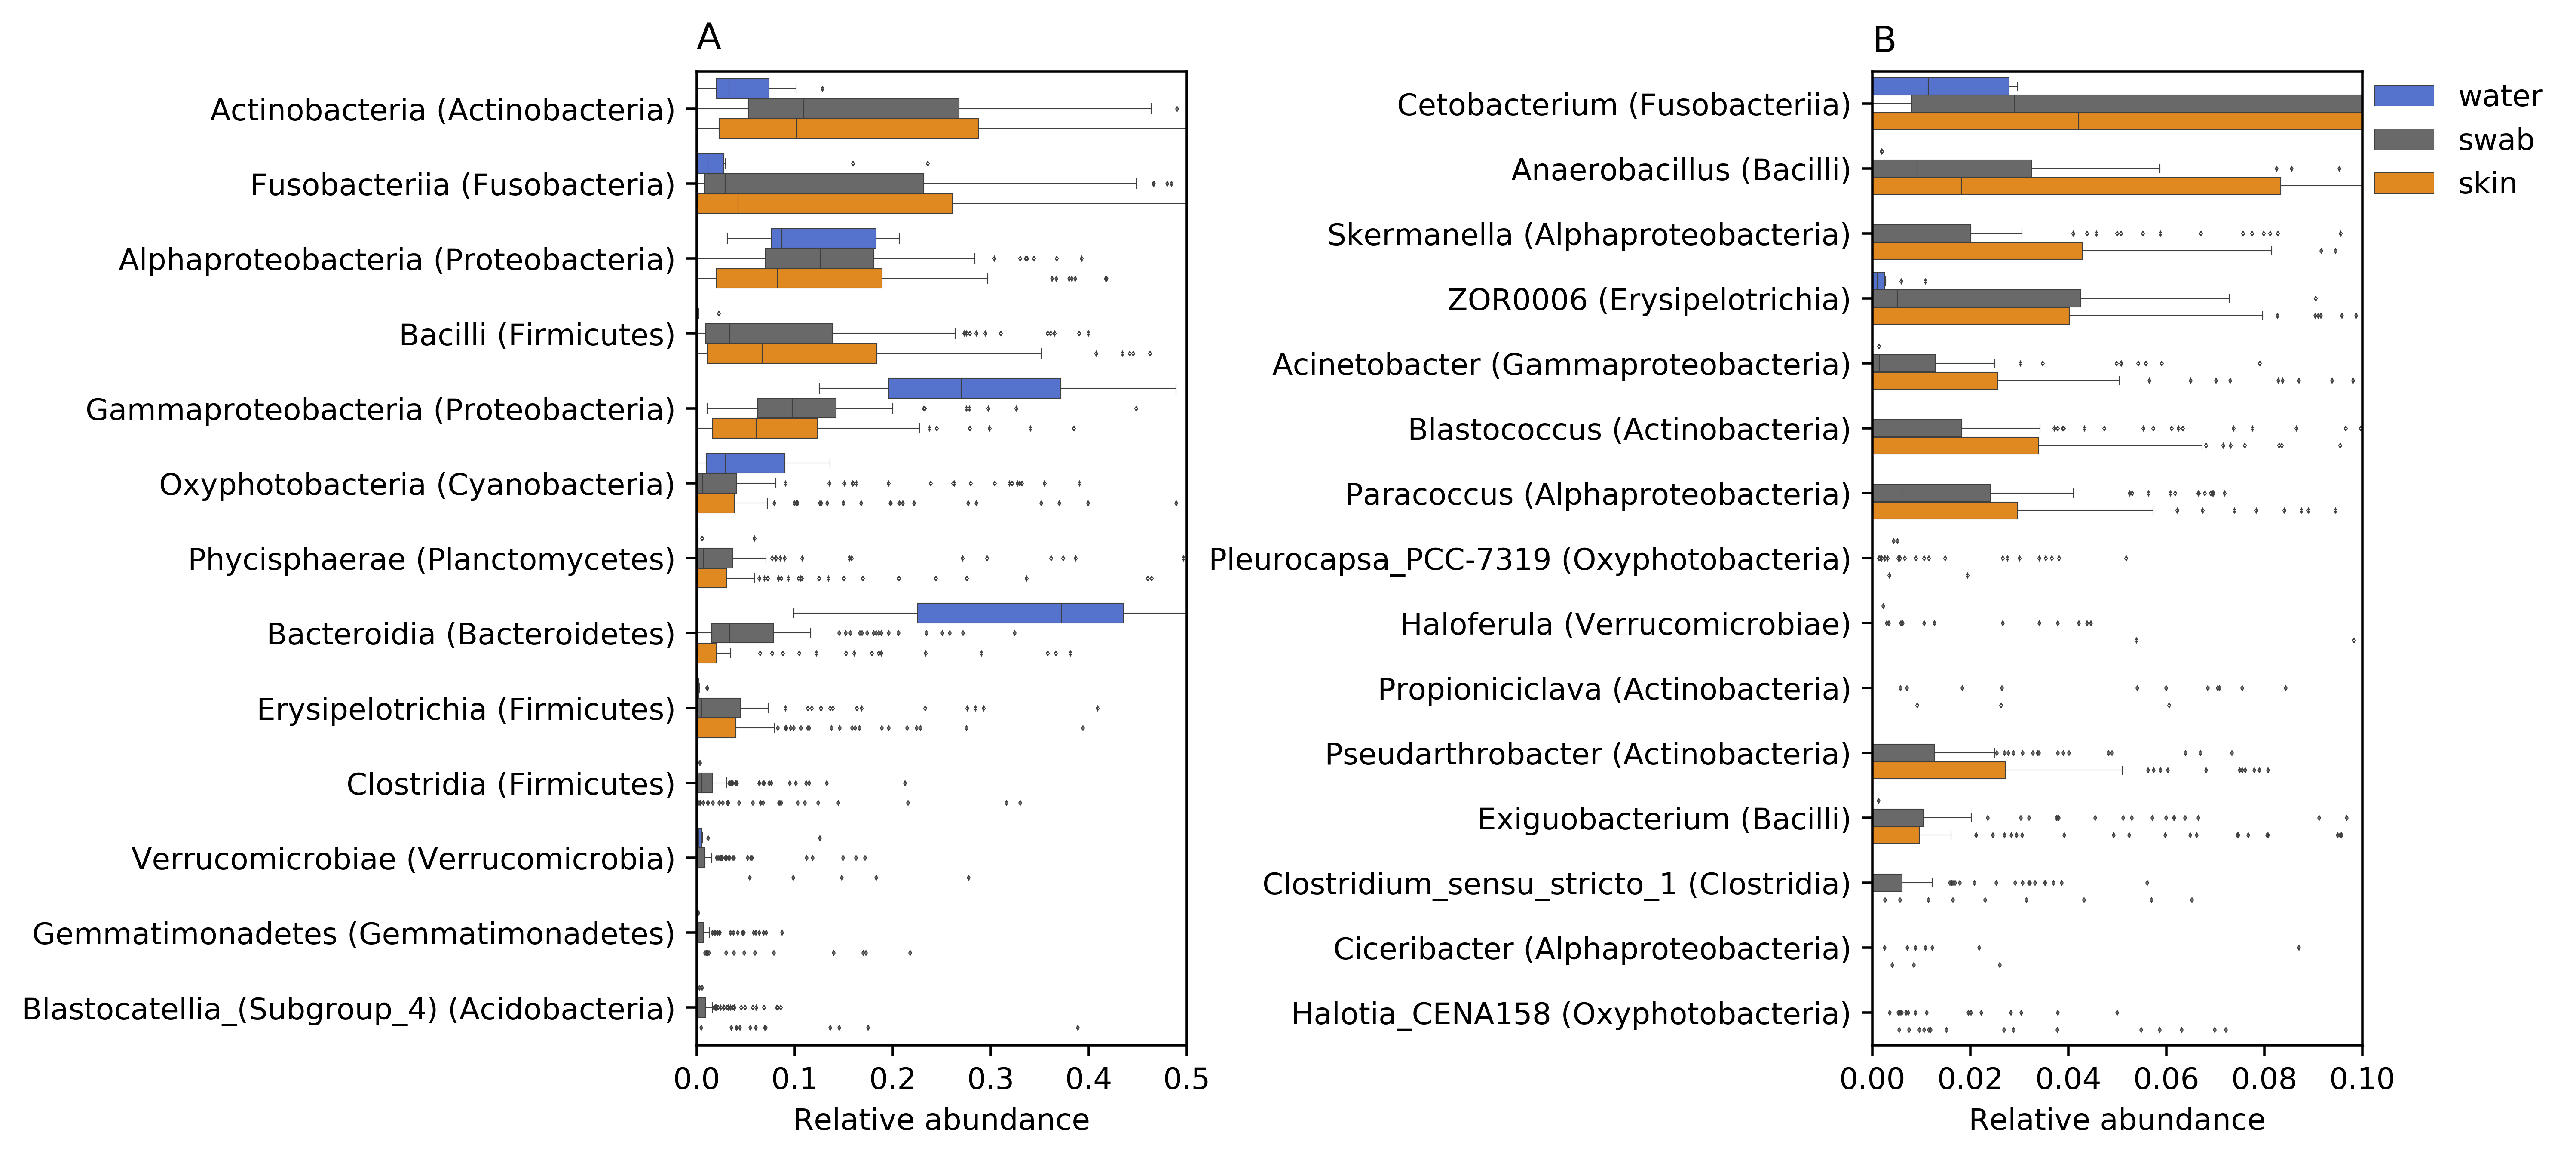

In [85]:
fig = plt.figure(figsize=(10,6),dpi=500)
gs = GridSpec(1, 2, width_ratios=[1, 1], wspace=1.4)
axes = []
for ax in gs:
    axes.append(fig.add_subplot(ax))
    
ax = axes[0]

sns.boxplot(x='RelAbund',y='Class', 
            data=narrow3.loc[narrow3.ClassMean>0.01].sort_values('ClassMean', ascending=False), 
            hue='Type',
            ax=ax,
            fliersize=0.2,
            linewidth=0.3,
            whis=1, 
            hue_order=['water','swab','skin'],
            palette=['royalblue','dimgrey','darkorange']
           )
ax.set_xlim(0,0.5)
ax.set_ylabel('')
ax.set_xlabel('Relative abundance')
ax.legend().remove()
ax.text(0,-0.8,'A',fontdict={'fontsize': 12})
ax.set_yticklabels(['%s (%s)' % (i.get_text(),narrow3.loc[narrow3.Class == i.get_text()].Phylum.tolist()[0]) for i in ax.get_yticklabels()],
                   fontdict={'fontsize': 10})

ax = axes[1]

sns.boxplot(x='RelAbund',y='Genus', 
            data=narrow6.loc[narrow6.GenusMean>0.0135].sort_values('GenusMean', ascending=False), 
            hue='Type',
            ax=ax,
            fliersize=0.2,
            linewidth=0.3,
            whis=1, 
            hue_order=['water','swab','skin'],
            palette=['royalblue','dimgrey','darkorange']
           )

ax.set_xlim(0,0.1)
ax.set_ylabel('')
ax.set_xlabel('Relative abundance')
ax.legend().remove()
ax.text(0,-0.8,'B',fontdict={'fontsize': 12})
ax.set_yticklabels(['%s (%s)' % (i.get_text(),narrow6.loc[narrow6.Genus == i.get_text()].Class.tolist()[0]) for i in ax.get_yticklabels()],
                   fontdict={'fontsize': 10})
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,fontsize='medium',frameon=False)
fig.savefig('Figures/relative_abundances.png',bbox_inches='tight')

#### Describe level unique taxa

In [126]:
narrow6swab = narrow6.loc[((narrow6.Type=='swab') & (narrow6.RelAbund > 0))]
narrow6skin = narrow6.loc[((narrow6.Type=='skin') & (narrow6.RelAbund > 0))]
print
print "Unique genera in raw swab communities"
print
for genus in set(narrow6swab.Genus):
    if len(set(narrow6swab.loc[narrow6swab.Genus==genus]['Sample'])) < 4:
        continue
    if len(set(narrow6swab.loc[narrow6swab.Genus==genus]['Basin'])) == 1:
        print "Genus %s is unique to Basin %s" % (genus, list(set(narrow6swab.loc[narrow6swab.Genus==genus]['Basin']))[0])
    if len(set(narrow6swab.loc[narrow6swab.Genus==genus]['Stream'])) == 1:
        print "Genus %s is unique to Stream %s" % (genus, list(set(narrow6swab.loc[narrow6swab.Genus==genus]['Stream']))[0])
    if len(set(narrow6swab.loc[narrow6swab.Genus==genus]['Site'])) == 1:
        print "Genus %s is unique to Site %s" % (genus, list(set(narrow6swab.loc[narrow6swab.Genus==genus]['Site']))[0])
    if len(set(narrow6swab.loc[narrow6swab.Genus==genus]['family_or_tribe'])) == 1:
        print "Genus %s is unique to Family/Tribe %s" % (genus, list(set(narrow6swab.loc[narrow6swab.Genus==genus]['family_or_tribe']))[0])
    if len(set(narrow6swab.loc[narrow6swab.Genus==genus]['Species'])) == 1:
        print "Genus %s is unique to Species %s" % (genus, list(set(narrow6swab.loc[narrow6swab.Genus==genus]['Species']))[0])
print 
print "Unique genera in corrected skin communities"        
print
for genus in set(narrow6skin.Genus):
    if len(set(narrow6skin.loc[narrow6skin.Genus==genus]['Sample'])) < 4:
        continue
    if len(set(narrow6skin.loc[narrow6skin.Genus==genus]['Basin'])) == 1:
        print "Genus %s is unique to Basin %s" % (genus, list(set(narrow6skin.loc[narrow6skin.Genus==genus]['Basin']))[0])
    if len(set(narrow6skin.loc[narrow6skin.Genus==genus]['Stream'])) == 1:
        print "Genus %s is unique to Stream %s" % (genus, list(set(narrow6skin.loc[narrow6skin.Genus==genus]['Stream']))[0])
    if len(set(narrow6skin.loc[narrow6skin.Genus==genus]['Site'])) == 1:
        print "Genus %s is unique to Site %s" % (genus, list(set(narrow6skin.loc[narrow6skin.Genus==genus]['Site']))[0])
    if len(set(narrow6skin.loc[narrow6skin.Genus==genus]['family_or_tribe'])) == 1:
        print "Genus %s is unique to Family/Tribe %s" % (genus, list(set(narrow6skin.loc[narrow6skin.Genus==genus]['family_or_tribe']))[0])
    if len(set(narrow6skin.loc[narrow6skin.Genus==genus]['Species'])) == 1:
        print "Genus %s is unique to Species %s" % (genus, list(set(narrow6skin.loc[narrow6skin.Genus==genus]['Species']))[0])

narrow3swab = narrow3.loc[((narrow3.Type=='swab') & (narrow3.RelAbund > 0))]
narrow3skin = narrow3.loc[((narrow3.Type=='skin') & (narrow3.RelAbund > 0))]        

print
print "Unique classes in raw swab communities"
print
for cls in set(narrow3swab.Class):
    if len(set(narrow3swab.loc[narrow3swab.Class==cls]['Sample'])) < 4:
        continue
    if len(set(narrow3swab.loc[narrow3swab.Class==cls]['Basin'])) == 1:
        print "Class %s is unique to Basin %s" % (cls, list(set(narrow3swab.loc[narrow3swab.Class==cls]['Basin']))[0])
    if len(set(narrow3swab.loc[narrow3swab.Class==cls]['Stream'])) == 1:
        print "Class %s is unique to Stream %s" % (cls, list(set(narrow3swab.loc[narrow3swab.Class==cls]['Stream']))[0])
    if len(set(narrow3swab.loc[narrow3swab.Class==cls]['Site'])) == 1:
        print "Class %s is unique to Site %s" % (cls, list(set(narrow3swab.loc[narrow3swab.Class==cls]['Site']))[0])
    if len(set(narrow3swab.loc[narrow3swab.Class==cls]['family_or_tribe'])) == 1:
        print "Class %s is unique to Family/Tribe %s" % (cls, list(set(narrow3swab.loc[narrow3swab.Class==cls]['family_or_tribe']))[0])
    if len(set(narrow3swab.loc[narrow3swab.Class==cls]['Species'])) == 1:
        print "Class %s is unique to Species %s" % (cls, list(set(narrow3swab.loc[narrow3swab.Class==cls]['Species']))[0])
print
print "Unique classes in corrected skin communities" 
print
for cls in set(narrow3skin.Class):
    if len(set(narrow3skin.loc[narrow3skin.Class==cls]['Sample'])) < 4:
        continue
    if len(set(narrow3skin.loc[narrow3skin.Class==cls]['Basin'])) == 1:
        print "Class %s is unique to Basin %s" % (cls, list(set(narrow3skin.loc[narrow3skin.Class==cls]['Basin']))[0])
    if len(set(narrow3skin.loc[narrow3skin.Class==cls]['Stream'])) == 1:
        print "Class %s is unique to Stream %s" % (cls, list(set(narrow3skin.loc[narrow3skin.Class==cls]['Stream']))[0])
    if len(set(narrow3skin.loc[narrow3skin.Class==cls]['Site'])) == 1:
        print "Class %s is unique to Site %s" % (cls, list(set(narrow3skin.loc[narrow3skin.Class==cls]['Site']))[0])
    if len(set(narrow3skin.loc[narrow3skin.Class==cls]['family_or_tribe'])) == 1:
        print "Class %s is unique to Family/Tribe %s" % (cls, list(set(narrow3skin.loc[narrow3skin.Class==cls]['family_or_tribe']))[0])
    if len(set(narrow3skin.loc[narrow3skin.Class==cls]['Species'])) == 1:
        print "Class %s is unique to Species %s" % (cls, list(set(narrow3skin.loc[narrow3skin.Class==cls]['Species']))[0])


Unique genera in raw swab communities

Genus Actinotalea is unique to Basin N
Genus Actinotalea is unique to Stream J
Genus Janibacter is unique to Basin N
Genus Flavihumibacter is unique to Basin N
Genus Flavihumibacter is unique to Stream S
Genus Flavihumibacter is unique to Site S.3
Genus Flavihumibacter is unique to Family/Tribe Cyprinidae
Genus Flaviaesturariibacter is unique to Basin N
Genus Dielma is unique to Basin N
Genus Dielma is unique to Family/Tribe Cyprinidae
Genus Solibacillus is unique to Basin N
Genus Solibacillus is unique to Stream J
Genus Solibacillus is unique to Site J.2
Genus Cyanobium_PCC-6307 is unique to Basin S
Genus Christensenellaceae_R-7_group is unique to Basin N
Genus Christensenellaceae_R-7_group is unique to Stream S
Genus Christensenellaceae_R-7_group is unique to Site S.3
Genus Christensenellaceae_R-7_group is unique to Family/Tribe Cyprinidae
Genus Micromonospora is unique to Basin N
Genus Agromyces is unique to Basin N
Genus Sandaracinobacter is 

## Diversity analyses
#### Calculate distance matrices and alpha diversity - Full table

In [56]:
%%bash

source activate qiime2-2019.4

qiime diversity core-metrics-phylogenetic \
  --i-table input_qza/dada_table.no_ntc.min2.qza \
  --p-sampling-depth 1000 \
  --i-phylogeny input_qza/rooted-tree.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --output-dir  diversity

Saved FeatureTable[Frequency] to: diversity/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: diversity/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: diversity/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: diversity/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: diversity/evenness_vector.qza
Saved DistanceMatrix % Properties('phylogenetic') to: diversity/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties('phylogenetic') to: diversity/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: diversity/jaccard_distance_matrix.qza
Saved DistanceMatrix to: diversity/bray_curtis_distance_matrix.qza
Saved PCoAResults to: diversity/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: diversity/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: diversity/jaccard_pcoa_results.qza
Saved PCoAResults to: diversity/bray_curtis_pcoa_results.qza
Saved Visualization to: diversity/unweighted_unifr

#### Make Rarefaction curve

In [57]:
%%bash


source activate qiime2-2019.4

qiime diversity alpha-rarefaction \
 --i-table input_qza/dada_table.no_ntc.min2.qza \
 --p-max-depth 6000 \
 --i-phylogeny input_qza/rooted-tree.qza \
 --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
 --p-steps 10 \
 --o-visualization diversity/rarefaction_curve.qzv

Saved Visualization to: diversity/rarefaction_curve.qzv


#### Calculate distance matrices and alpha diversity - Swab table

In [58]:
%%bash

source activate qiime2-2019.4

qiime diversity core-metrics-phylogenetic \
  --i-table input_qza/dada_table.no_water_or_ntc.min2.qza \
  --p-sampling-depth 1000 \
  --i-phylogeny input_qza/rooted-tree.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --output-dir  diversity-swab

Saved FeatureTable[Frequency] to: diversity-swab/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: diversity-swab/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: diversity-swab/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: diversity-swab/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: diversity-swab/evenness_vector.qza
Saved DistanceMatrix % Properties('phylogenetic') to: diversity-swab/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties('phylogenetic') to: diversity-swab/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: diversity-swab/jaccard_distance_matrix.qza
Saved DistanceMatrix to: diversity-swab/bray_curtis_distance_matrix.qza
Saved PCoAResults to: diversity-swab/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: diversity-swab/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: diversity-swab/jaccard_pcoa_results.qza
Saved PCoAResults to: diversity-swab/bray_curtis_pc

#### Calculate distance matrices and alpha diversity - Skin table

In [59]:
%%bash

source activate qiime2-2019.4

qiime diversity core-metrics-phylogenetic \
  --i-table denoised_tables/skin_microbiome.qza \
  --p-sampling-depth 500 \
  --i-phylogeny input_qza/rooted-tree.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --output-dir  diversity-skin

Saved FeatureTable[Frequency] to: diversity-skin/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: diversity-skin/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: diversity-skin/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: diversity-skin/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: diversity-skin/evenness_vector.qza
Saved DistanceMatrix % Properties('phylogenetic') to: diversity-skin/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties('phylogenetic') to: diversity-skin/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: diversity-skin/jaccard_distance_matrix.qza
Saved DistanceMatrix to: diversity-skin/bray_curtis_distance_matrix.qza
Saved PCoAResults to: diversity-skin/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: diversity-skin/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: diversity-skin/jaccard_pcoa_results.qza
Saved PCoAResults to: diversity-skin/bray_curtis_pc

In [60]:
%%bash


source activate qiime2-2019.4

qiime diversity alpha-rarefaction \
 --i-table denoised_tables/skin_microbiome.qza \
 --p-max-depth 4000 \
 --i-phylogeny input_qza/rooted-tree.qza \
 --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
 --p-steps 10 \
 --o-visualization diversity-skin/rarefaction_curve.qzv

Saved Visualization to: diversity-skin/rarefaction_curve.qzv


#### Alpha and beta significance

In [61]:
%%bash

source activate qiime2-2019.4

mkdir -p significance

qiime diversity alpha-group-significance \
  --i-alpha-diversity diversity-swab/faith_pd_vector.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --o-visualization significance/swab-faith-pd-group-significance.qzv


qiime diversity alpha-group-significance \
  --i-alpha-diversity diversity-skin/faith_pd_vector.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --o-visualization significance/skin-faith-pd-group-significance.qzv


qiime diversity beta-group-significance \
  --i-distance-matrix diversity-swab/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --m-metadata-column Location \
  --o-visualization significance/swab-unweighted-unifrac-Location-significance.qzv \
  --p-pairwise
qiime diversity beta-group-significance \
  --i-distance-matrix diversity-swab/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --m-metadata-column family_or_tribe \
  --o-visualization significance/swab-unweighted-unifrac-family_or_tribe-significance.qzv \
  --p-pairwise
qiime diversity beta-group-significance \
  --i-distance-matrix diversity-swab/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --m-metadata-column Stream \
  --o-visualization significance/swab-unweighted-unifrac-Stream-significance.qzv \
  --p-pairwise

qiime diversity beta-group-significance \
  --i-distance-matrix diversity-skin/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --m-metadata-column Location \
  --o-visualization significance/skin-unweighted-unifrac-Location-significance.qzv \
  --p-pairwise
qiime diversity beta-group-significance \
  --i-distance-matrix diversity-skin/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --m-metadata-column family_or_tribe \
  --o-visualization significance/skin-unweighted-unifrac-family_or_tribe-significance.qzv \
  --p-pairwise
qiime diversity beta-group-significance \
  --i-distance-matrix diversity-skin/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --m-metadata-column Stream \
  --o-visualization significance/skin-unweighted-unifrac-Stream-significance.qzv \
  --p-pairwise


Saved Visualization to: significance/swab-faith-pd-group-significance.qzv
Saved Visualization to: significance/skin-faith-pd-group-significance.qzv
Saved Visualization to: significance/swab-unweighted-unifrac-Location-significance.qzv
Saved Visualization to: significance/swab-unweighted-unifrac-family_or_tribe-significance.qzv
Saved Visualization to: significance/swab-unweighted-unifrac-Stream-significance.qzv
Saved Visualization to: significance/skin-unweighted-unifrac-Location-significance.qzv
Saved Visualization to: significance/skin-unweighted-unifrac-family_or_tribe-significance.qzv
Saved Visualization to: significance/skin-unweighted-unifrac-Stream-significance.qzv


#### Alpha significance - Family/Tribe

In [62]:
qza = 'significance/skin-faith-pd-group-significance.qzv'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/kruskal-wallis-pairwise-family_or_tribe.csv'
faith_pd_p_val_skin = pd.read_csv(inf)
!rm -r $digest

qza = 'significance/swab-faith-pd-group-significance.qzv'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/kruskal-wallis-pairwise-family_or_tribe.csv'
faith_pd_p_val_swab = pd.read_csv(inf)
!rm -r $digest

faith_pd_p_val_skin = faith_pd_p_val_skin.sort_values('q-value')
faith_pd_p_val_swab = faith_pd_p_val_swab.sort_values('q-value')
faith_pd_p_val_skin['Type'] = 'skin'
faith_pd_p_val_swab['Type'] = 'swab'
faith_pd_p_val = pd.concat([faith_pd_p_val_skin,faith_pd_p_val_swab]).reset_index().drop('index',axis=1)


def color_sig_red(val):
    if val < 0.05:
        return 'color: red'
    elif val == 'skin':
        return 'color: darkorange'
    elif val == 'swab':
        return 'color: dimgrey'
    else:
        return 'color: black'

s = faith_pd_p_val.style.applymap(color_sig_red, subset=['q-value','Type'])
s.to_excel('Tables/Alpha_group_significance_Family_Tribe.xlsx',index=False)
s

#### Alpha significance - Stream

In [63]:
qza = 'significance/skin-faith-pd-group-significance.qzv'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/kruskal-wallis-pairwise-Stream.csv'
faith_pd_p_val_skin = pd.read_csv(inf)
!rm -r $digest

qza = 'significance/swab-faith-pd-group-significance.qzv'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/kruskal-wallis-pairwise-Stream.csv'
faith_pd_p_val_swab = pd.read_csv(inf)
!rm -r $digest

faith_pd_p_val_skin = faith_pd_p_val_skin.sort_values('q-value')
faith_pd_p_val_swab = faith_pd_p_val_swab.sort_values('q-value')
faith_pd_p_val_skin['Type'] = 'skin'
faith_pd_p_val_swab['Type'] = 'swab'
faith_pd_p_val = pd.concat([faith_pd_p_val_skin,faith_pd_p_val_swab]).reset_index().drop('index',axis=1)


def color_sig_red(val):
    if val < 0.05:
        return 'color: red'
    elif val == 'skin':
        return 'color: darkorange'
    elif val == 'swab':
        return 'color: dimgrey'
    else:
        return 'color: black'

s = faith_pd_p_val.style.applymap(color_sig_red, subset=['q-value','Type'])
s.to_excel('Tables/Alpha_group_significance_Stream.xlsx',index=False)
s

#### Beta significance - family or tribe

In [64]:
qza = 'significance/skin-unweighted-unifrac-family_or_tribe-significance.qzv'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/permanova-pairwise.csv'
permanova_p_val_skin = pd.read_csv(inf)
!rm -r $digest

qza = 'significance/swab-unweighted-unifrac-family_or_tribe-significance.qzv'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/permanova-pairwise.csv'
permanova_p_val_swab = pd.read_csv(inf)
!rm -r $digest

permanova_p_val_skin = permanova_p_val_skin.sort_values('q-value')
permanova_p_val_swab = permanova_p_val_swab.sort_values('q-value')
permanova_p_val_skin['Type'] = 'skin'
permanova_p_val_swab['Type'] = 'swab'
permanova_p_val = pd.concat([permanova_p_val_skin,permanova_p_val_swab]).reset_index().drop('index',axis=1)


def color_sig_red(val):
    if val < 0.05:
        return 'color: red'
    elif val == 'skin':
        return 'color: darkorange'
    elif val == 'swab':
        return 'color: dimgrey'
    else:
        return 'color: black'

s = permanova_p_val.style.applymap(color_sig_red, subset=['q-value','Type'])
s.to_excel('Tables/Beta_group_significance_Family_Tribe.xlsx',index=False)
s

#### Beta significance - Stream

In [65]:
qza = 'significance/skin-unweighted-unifrac-Stream-significance.qzv'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/permanova-pairwise.csv'
permanova_p_val_skin = pd.read_csv(inf)
!rm -r $digest

qza = 'significance/swab-unweighted-unifrac-Stream-significance.qzv'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/permanova-pairwise.csv'
permanova_p_val_swab = pd.read_csv(inf)
!rm -r $digest

permanova_p_val_skin = permanova_p_val_skin.sort_values('q-value')
permanova_p_val_swab = permanova_p_val_swab.sort_values('q-value')
permanova_p_val_skin['Type'] = 'skin'
permanova_p_val_swab['Type'] = 'swab'
permanova_p_val = pd.concat([permanova_p_val_skin,permanova_p_val_swab]).reset_index().drop('index',axis=1)


def color_sig_red(val):
    if val < 0.05:
        return 'color: red'
    elif val == 'skin':
        return 'color: darkorange'
    elif val == 'swab':
        return 'color: dimgrey'
    else:
        return 'color: black'

s = permanova_p_val.style.applymap(color_sig_red, subset=['q-value','Type'])
s.to_excel('Tables/Beta_group_significance_Stream.xlsx',index=False)
s

#### Create biplots to investigate differences between water and swab samples - Full table

In [66]:
%%bash

source activate qiime2-2019.4

qiime feature-table filter-samples \
  --i-table input_qza/dada_table.no_ntc.min2.qza \
  --p-min-frequency 1000 \
  --o-filtered-table temp.qza

qiime feature-table relative-frequency \
 --i-table temp.qza \
 --o-relative-frequency-table temp.qza 

qiime diversity pcoa-biplot \
  --i-pcoa diversity/unweighted_unifrac_pcoa_results.qza \
  --i-features temp.qza \
  --o-biplot diversity/unweighted_unifrac_pcoa_results_biplot.qza

qiime feature-table filter-samples \
  --i-table input_qza/dada_table.no_water_or_ntc.min2.qza \
  --p-min-frequency 1000 \
  --o-filtered-table temp.qza

qiime feature-table relative-frequency \
 --i-table temp.qza \
 --o-relative-frequency-table temp.qza 

qiime diversity pcoa-biplot \
  --i-pcoa diversity-swab/unweighted_unifrac_pcoa_results.qza \
  --i-features temp.qza \
  --o-biplot diversity-swab/unweighted_unifrac_pcoa_results_biplot.qza

qiime feature-table filter-samples \
  --i-table denoised_tables/skin_microbiome.qza \
  --p-min-frequency 500 \
  --o-filtered-table temp.qza

qiime feature-table relative-frequency \
 --i-table temp.qza \
 --o-relative-frequency-table temp.qza 

qiime diversity pcoa-biplot \
  --i-pcoa diversity-skin/unweighted_unifrac_pcoa_results.qza \
  --i-features temp.qza \
  --o-biplot diversity-skin/unweighted_unifrac_pcoa_results_biplot.qza


rm temp.qza

Saved FeatureTable[Frequency] to: temp.qza
Saved FeatureTable[RelativeFrequency] to: temp.qza
Saved PCoAResults % Properties('biplot') to: diversity/unweighted_unifrac_pcoa_results_biplot.qza
Saved FeatureTable[Frequency] to: temp.qza
Saved FeatureTable[RelativeFrequency] to: temp.qza
Saved PCoAResults % Properties('biplot') to: diversity-swab/unweighted_unifrac_pcoa_results_biplot.qza
Saved FeatureTable[Frequency] to: temp.qza
Saved FeatureTable[RelativeFrequency] to: temp.qza
Saved PCoAResults % Properties('biplot') to: diversity-skin/unweighted_unifrac_pcoa_results_biplot.qza


#### Regression

In [4]:
regression = pd.read_csv('fish_samples_metadata_loc_code_correct_sp.tsv',index_col=0, sep='\t')

def parse_biplot(qza):
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ','')
    inf = digest + '/data/ordination.txt'
    lines = open(inf,'r').readlines()
    Eigvals = [float(i) for i in lines[1].rstrip().split('\t')]
    Proportion = [float(i) for i in lines[4].rstrip().split('\t')]
    biplot_skiprows = 7
    biplot_skipfoot = len(open(inf,'r').read().split('Site')[1].splitlines()) + 1
    pcoa_skiprows = len(open(inf,'r').read().split('Site')[0].splitlines()) + 1
    pcoa_skipfoot = 4
    pcoa = pd.read_csv(inf, index_col=0, skiprows=pcoa_skiprows, skipfooter=pcoa_skipfoot, header=None,sep='\t')
    biplot = pd.read_csv(inf, index_col=0, skiprows=biplot_skiprows, skipfooter=biplot_skipfoot, header=None,sep='\t')
    !rm -r $digest
    return  pcoa, biplot, Eigvals, Proportion

qza = 'diversity/unweighted_unifrac_pcoa_results_biplot.qza'
swab_ordination, swab_biplot, swab_Eigvals, swab_Proportion = parse_biplot(qza)

qza = 'diversity-skin/unweighted_unifrac_pcoa_results_biplot.qza'
skin_ordination, skin_biplot, skin_Eigvals, skin_Proportion = parse_biplot(qza)

qza = 'diversity/faith_pd_vector.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/alpha-diversity.tsv'
faith_pd_all = pd.read_csv(inf,index_col=0,sep='\t')
!rm -r $digest

qza = 'diversity-swab/faith_pd_vector.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/alpha-diversity.tsv'
faith_pd_swab = pd.read_csv(inf,index_col=0,sep='\t')
!rm -r $digest

qza = 'diversity-skin/faith_pd_vector.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/alpha-diversity.tsv'
faith_pd_skin = pd.read_csv(inf,index_col=0,sep='\t')
!rm -r $digest

def get_skin_axis_1(index):
    try:
        return skin_ordination.at[index,1]
    except:
        return np.nan

def get_skin_axis_2(index):
    try:
        return skin_ordination.at[index,2]
    except:
        return np.nan

def get_swab_axis_1(index):
    try:
        return swab_ordination.at[index,1]
    except:
        return np.nan

def get_swab_axis_2(index):
    try:
        return swab_ordination.at[index,2]
    except:
        return np.nan

def get_swab_alpha(index):
    try:
        return faith_pd_swab.at[index,'faith_pd']
    except:
        return np.nan

def get_skin_alpha(index):
    try:
        return faith_pd_skin.at[index,'faith_pd']
    except:
        return np.nan
    
def get_water_alpha(index):
    try:
        return faith_pd_all.at[index,'faith_pd']
    except:
        return np.nan
    
regression['skin_axis_1'] = regression.index.map(get_skin_axis_1)
regression['skin_axis_2'] = regression.index.map(get_skin_axis_2)
regression['swab_axis_1'] = regression.index.map(get_swab_axis_1)
regression['swab_axis_2'] = regression.index.map(get_swab_axis_2)
regression['swab_faith_pd'] = regression.index.map(get_swab_alpha)
regression['skin_faith_pd'] = regression.index.map(get_skin_alpha)
regression['water_faith_pd'] = regression.index.map(get_water_alpha)
regression['skin_axis_1'] = regression['skin_axis_1'] * -1
regression['skin_axis_2'] = regression['skin_axis_2'] * -1
regression = regression.loc[(regression['type'].isin(['Water','Swab']) & (regression.Stream!='N'))]
regression['pH'] = regression.pH.astype(float)
regression['PercentO'] = regression.PercentO.astype(float)

print 'Swab Faith PD:', \
       regression.loc[regression['type'] == 'Swab']['swab_faith_pd'].mean(), \
       u'\N{PLUS-MINUS SIGN}', \
       regression.loc[regression['type'] == 'Swab']['swab_faith_pd'].std()

print 'Skin Faith PD:', \
       regression.loc[regression['type'] == 'Swab']['skin_faith_pd'].mean(), \
       u'\N{PLUS-MINUS SIGN}', \
       regression.loc[regression['type'] == 'Swab']['skin_faith_pd'].std()

print 'Water Faith PD:', \
       regression.loc[regression['type'] == 'Water']['water_faith_pd'].mean(), \
       u'\N{PLUS-MINUS SIGN}', \
       regression.loc[regression['type'] == 'Water']['water_faith_pd'].std()

regression_no_water = regression.loc[regression['type'] == 'Swab']
R = regression_no_water.corr()
R2 = R*R

cm = sns.light_palette("green", as_cmap=True)

s = R2.style.background_gradient(cmap=cm)
s

/home/amir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  
/home/amir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


Swab Faith PD: 8.611800169633334 ± 2.5725125045658057
Skin Faith PD: 3.7123214745102033 ± 0.8277908871505085
Water Faith PD: 9.257114806699999 ± 2.1667832080163074


#### Plot alpha diversity

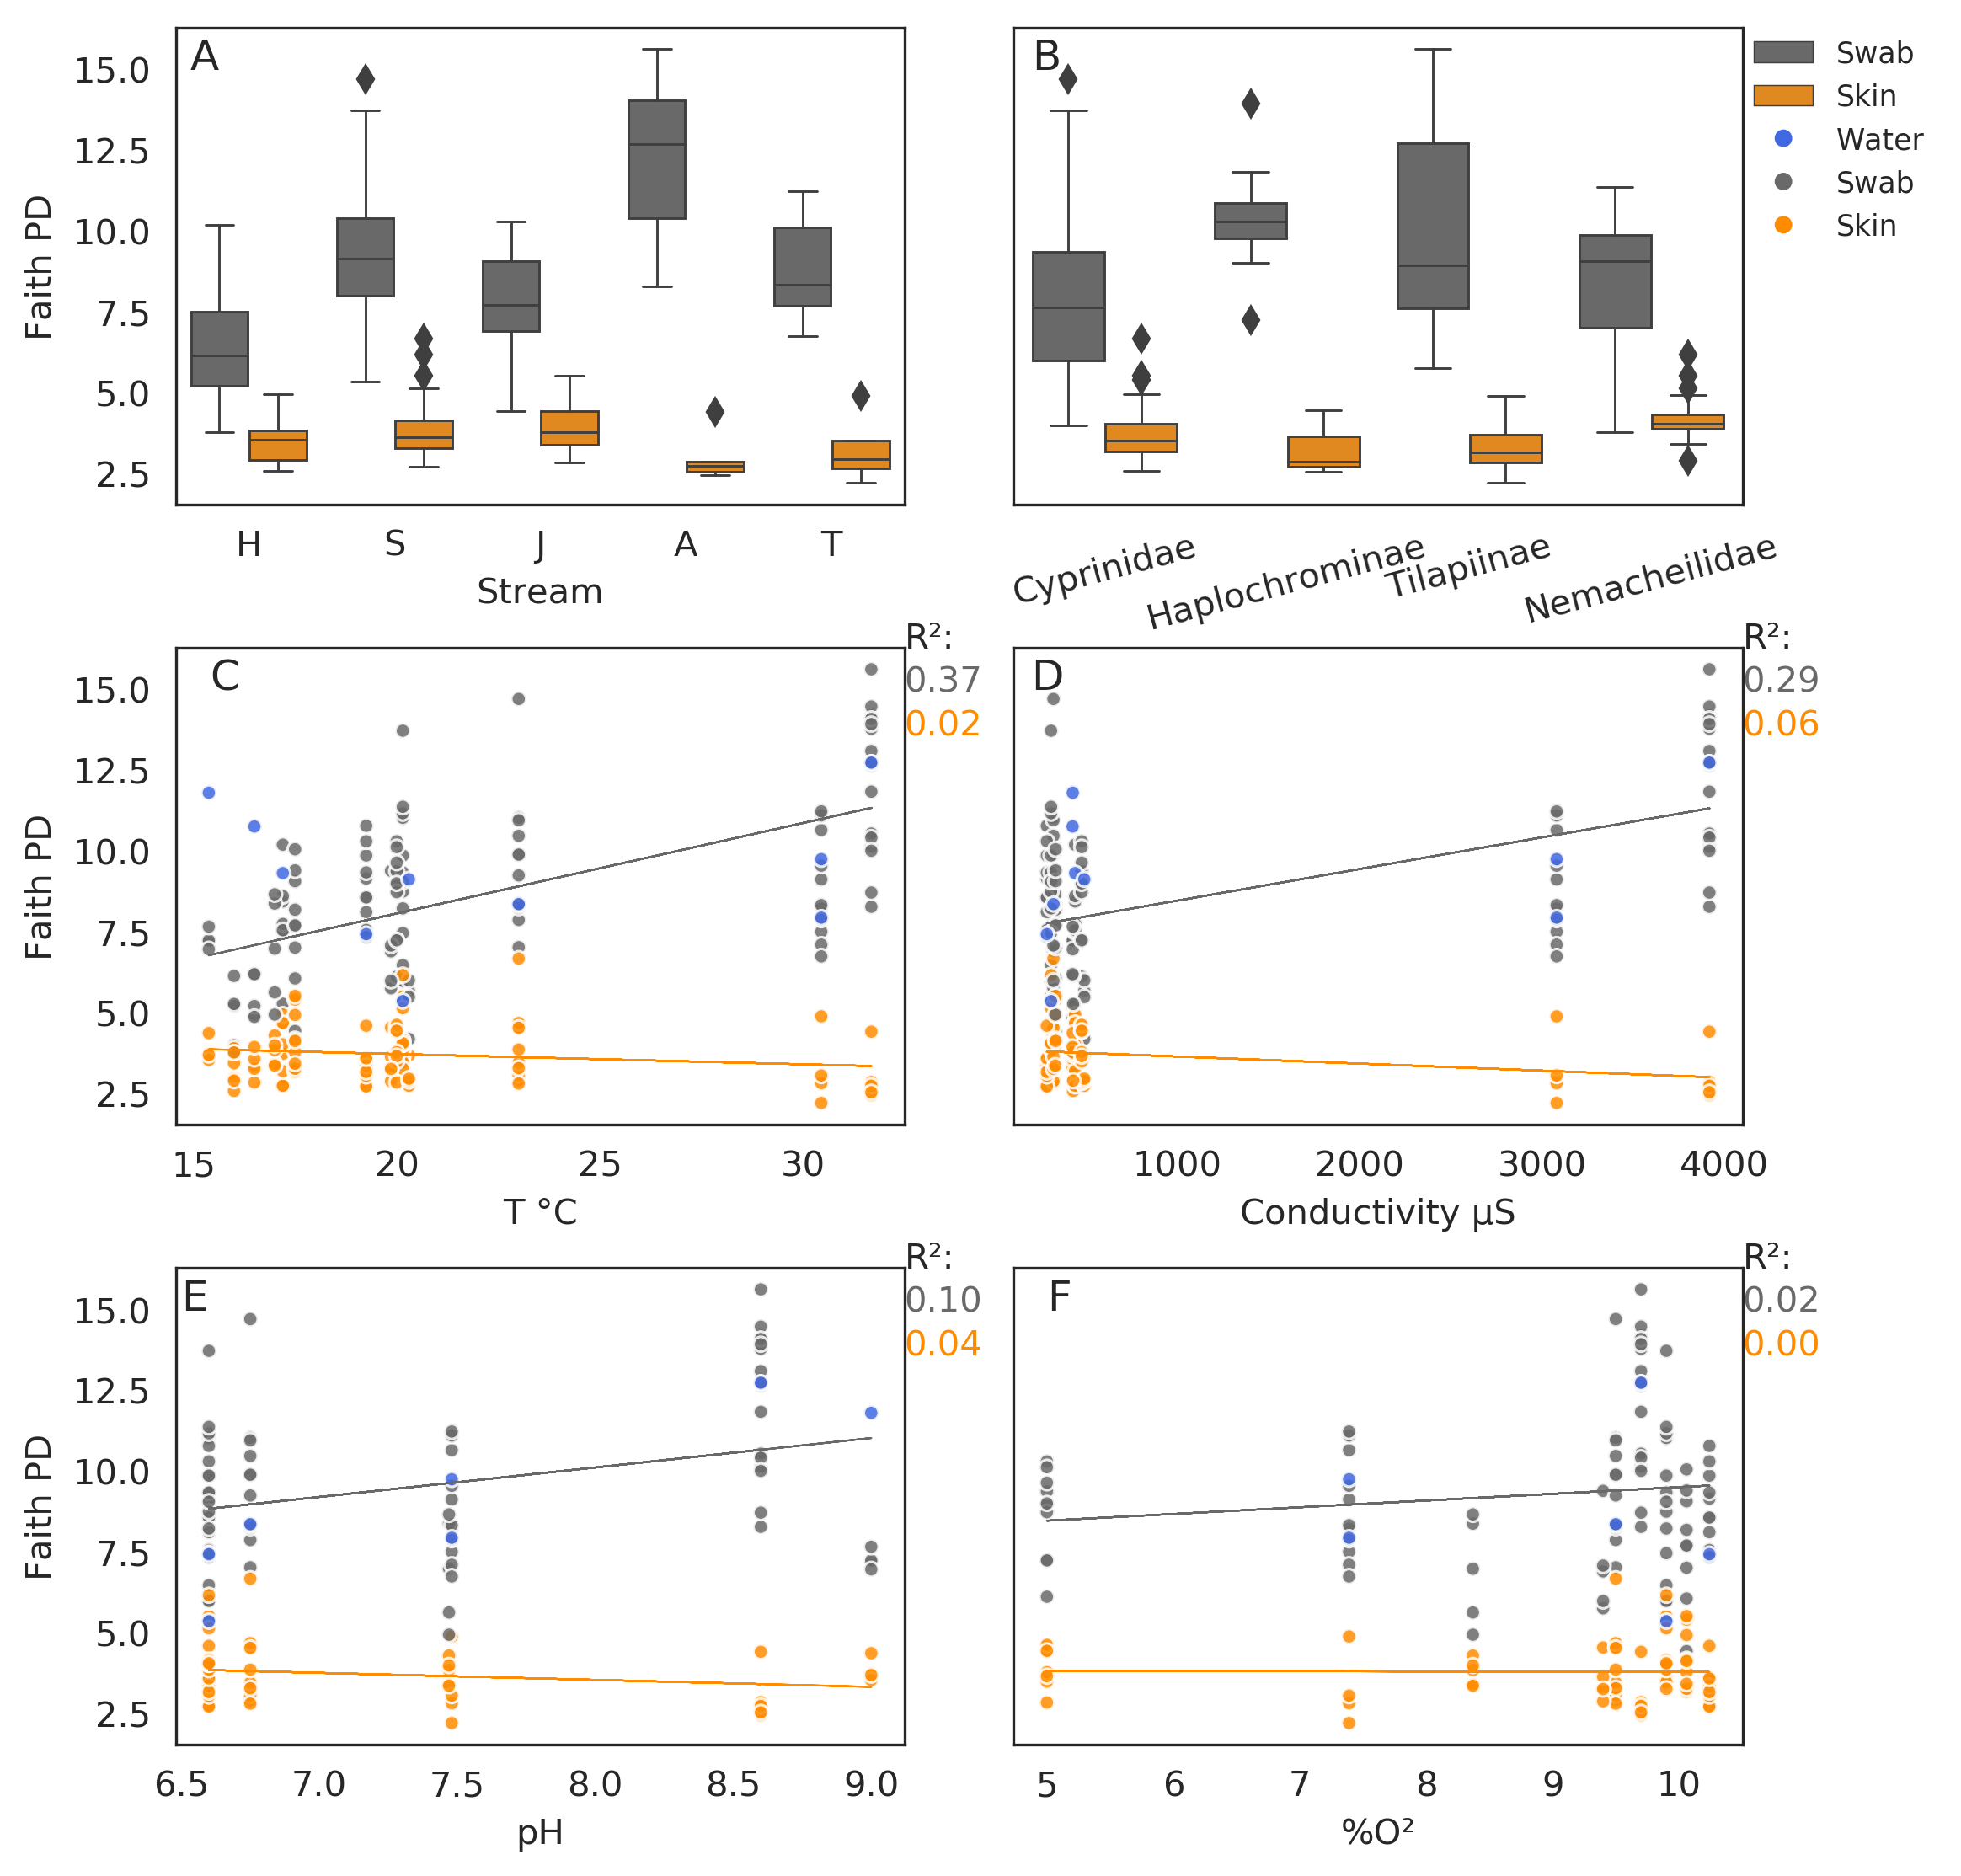

In [68]:
### Reshape the dataframe for easier plotting 

narrow = pd.DataFrame(columns=['Type', 'Stream','Family/Tribe','Faith PD',
                               u'T \N{DEGREE SIGN}C',u'Conductivity \N{Greek Small Letter Mu}S',
                               'pH',u'%O\u00b2'])

## Read Faith PD for all samples
qza = 'diversity/faith_pd_vector.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/alpha-diversity.tsv'
faith_pd = pd.read_csv(inf,index_col=0,sep='\t')
!rm -r $digest

## Write the reshaped dataframe
for ind, row in regression.iterrows():
    if row['type'] == 'Swab':
        narrow.loc[len(narrow)] = ['Swab',row['Stream'],row['family_or_tribe'],row['swab_faith_pd'],
                                   row['T'],row['Conductivity  '],row['pH'],row['PercentO']]
        narrow.loc[len(narrow)] = ['Skin',row['Stream'],row['family_or_tribe'],row['skin_faith_pd'],
                                   row['T'],row['Conductivity  '],row['pH'],row['PercentO']]
    if row['type'] == 'Water' and ind in faith_pd.index:
        narrow.loc[len(narrow)] = ['Water',row['Stream'],'Water',faith_pd.at[ind,'faith_pd'],row['T'],row['Conductivity  '],row['pH'],row['PercentO']]

### Define circular patches for the legend

class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Circle(xy=center,radius=2)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]


### Design figure layout

fig = plt.figure(figsize=(8,9),dpi=300)
gs = GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1],hspace=0.3, wspace=0.15)
axes = []
for ax in gs:
    axes.append(fig.add_subplot(ax))

### Draw boxplots

## Determine class orders in boxplots

stream_order = ['H','S','J','A','T']
family_or_tribe_order = ['Cyprinidae','Haplochrominae','Tilapiinae','Nemacheilidae']

## Draw Stream box plot

ax = axes[0]

sns.boxplot(
    x='Stream',
    y='Faith PD',
    data=narrow.loc[narrow.Type!='Water'],
    order=stream_order,
    hue = 'Type',
    hue_order = ['Swab','Skin'],
    ax=ax,
    palette=['dimgray','darkorange'],
    linewidth=0.7
)
# we don't want the legend in this ax
ax.get_legend().remove()
ax.text(-0.4,15,'A',fontdict={'size':12})


## Draw family/tribe box plot

ax = axes[1]

sns.boxplot(
    x='Family/Tribe',
    y='Faith PD',
    data=narrow.loc[narrow.Type!='Water'],
    order=family_or_tribe_order,
    hue = 'Type',
    hue_order = ['Swab','Skin'],
    ax=ax,
    palette=['dimgray','darkorange'],
    linewidth=0.7
)

ax.set_xlabel('')
ax.text(-0.4,15,'B',fontdict={'size':12})

## Draw the legend in this ax (top left)
# Extand legend to include bullets: 
handles, labels = ax.get_legend_handles_labels()
for color in ['royalblue','dimgray','darkorange']:
    handles += [mpatches.Circle([0.5,0.5],0.25,color=color)]
labels += ['Water','Swab','Skin']

# Draw the legend
ax.legend(handles, 
          labels,
          bbox_to_anchor=(1, 1),
          loc=2, 
          borderaxespad=0.,
          fontsize='small',
          frameon=False,
          handler_map={mpatches.Circle: HandlerCircle()}) 

# Style x and y axis
ax.set_xticklabels([i.get_text() for i in ax.get_xticklabels()],rotation=15)
ax.set_ylabel('')
ax.set_yticklabels([])
ax.yaxis.set_ticks_position('none')

### Draw regressions
## T scatterplot

ax = axes[2]
x=u'T \N{DEGREE SIGN}C'
y='Faith PD'
sns.scatterplot(y=y,
                x=x,
                data=narrow, 
                size=3,
                ax=ax,
                hue='Type',
                hue_order=['Swab','Skin','Water'],
                palette=['dimgray','darkorange','royalblue'],
                alpha=0.85)

## T regression (lines and R-sq)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()        
ax.text(xmax,ymax,u'R\u00b2:')

# Line for swabs
d = narrow.loc[narrow['Type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax.plot(d[x].values, line,color='dimgray',lw=0.5)
ax.text(xmax,ymax-(ymax/12),"%.2f"% (r_value*r_value),color='dimgray')

# Line for denoised skin
d = narrow.loc[narrow['Type'] == 'Skin',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax.plot(d[x].values, line,color='darkorange',lw=0.5)
ax.text(xmax,ymax-2*(ymax/12),"%.2f"% (r_value*r_value),color='darkorange')

# we don't want the legend in this ax
ax.get_legend().remove()
ax.text(15.4,15,'C',fontdict={'size':12})

## conductivity scatterplot

ax = axes[3]

x= u'Conductivity \N{Greek Small Letter Mu}S'
y='Faith PD'
sns.scatterplot(y=y,
                x=x,
                data=narrow, 
                size=3,
                ax=ax,
                hue='Type',
                hue_order=['Swab','Skin','Water'],
                palette=['dimgray','darkorange','royalblue'],
                alpha=0.85)
# Style x and y axes

ax.get_legend().remove()
ax.set_ylabel('')
ax.set_yticklabels([])
ax.yaxis.set_ticks_position('none') 

## Conductivity regression (lines and R-sq)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()        
ax.text(xmax,ymax,u'R\u00b2:')

# Swabs regression
d = narrow.loc[narrow['Type'] == 'Swab',[x,y]].dropna()
d = d.astype(float)
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax.plot(d[x].values, line,color='dimgray',lw=0.5)
ax.text(xmax,ymax-(ymax/12),"%.2f"% (r_value*r_value),color='dimgray')

# Skin regression
d = narrow.loc[narrow['Type'] == 'Skin',[x,y]].dropna()
d = d.astype(float)
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax.plot(d[x].values, line,color='darkorange',lw=0.5)
ax.text(xmax,ymax-2*(ymax/12),"%.2f"% (r_value*r_value),color='darkorange')

ax.text(200,15,'D',fontdict={'size':12})

## pH scatterplot

ax = axes[4]

x='pH'
y='Faith PD'
sns.scatterplot(y=y,
                x=x,
                data=narrow, 
                size=3,
                ax=ax,
                hue='Type',
                hue_order=['Swab','Skin','Water'],
                palette=['dimgray','darkorange','royalblue'],
                alpha=0.85)

## pH regression
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()        
ax.text(xmax,ymax,u'R\u00b2:')

d = narrow.loc[narrow['Type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax.plot(d[x].values, line,color='dimgray',lw=0.5)
ax.text(xmax,ymax-(ymax/12),"%.2f"% (r_value*r_value),color='dimgray')

d = narrow.loc[narrow['Type'] == 'Skin',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax.plot(d[x].values, line,color='darkorange',lw=0.5)
ax.text(xmax,ymax-2*(ymax/12),"%.2f"% (r_value*r_value),color='darkorange')

ax.get_legend().remove()
ax.text(6.5,15,'E',fontdict={'size':12})

## PercentO scatterplot

ax = axes[5]

x=u'%O\u00b2'
y='Faith PD'
sns.scatterplot(y=y,
                x=x,
                data=narrow, 
                size=3,
                ax=ax,
                hue='Type',
                hue_order=['Swab','Skin','Water'],
                palette=['dimgray','darkorange','royalblue'],
                alpha=0.85)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()        
ax.text(xmax,ymax,u'R\u00b2:')

## PercentO regression

d = narrow.loc[narrow['Type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax.plot(d[x].values, line,color='dimgray',lw=0.5)
ax.text(xmax,ymax-(ymax/12),"%.2f"% (r_value*r_value),color='dimgray')

d = narrow.loc[narrow['Type'] == 'Skin',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax.plot(d[x].values, line,color='darkorange',lw=0.5)
ax.text(xmax,ymax-2*(ymax/12),"%.2f"% (r_value*r_value),color='darkorange')

# Style x and y axes
ax.set_ylabel('')
ax.set_yticklabels([])
ax.yaxis.set_ticks_position('none') 
ax.text(5,15,'F',fontdict={'size':12})
ax.get_legend().remove()

fig.savefig('Figures/alpha_diversity.png')

#### Plot biplot and regression for skin and swab

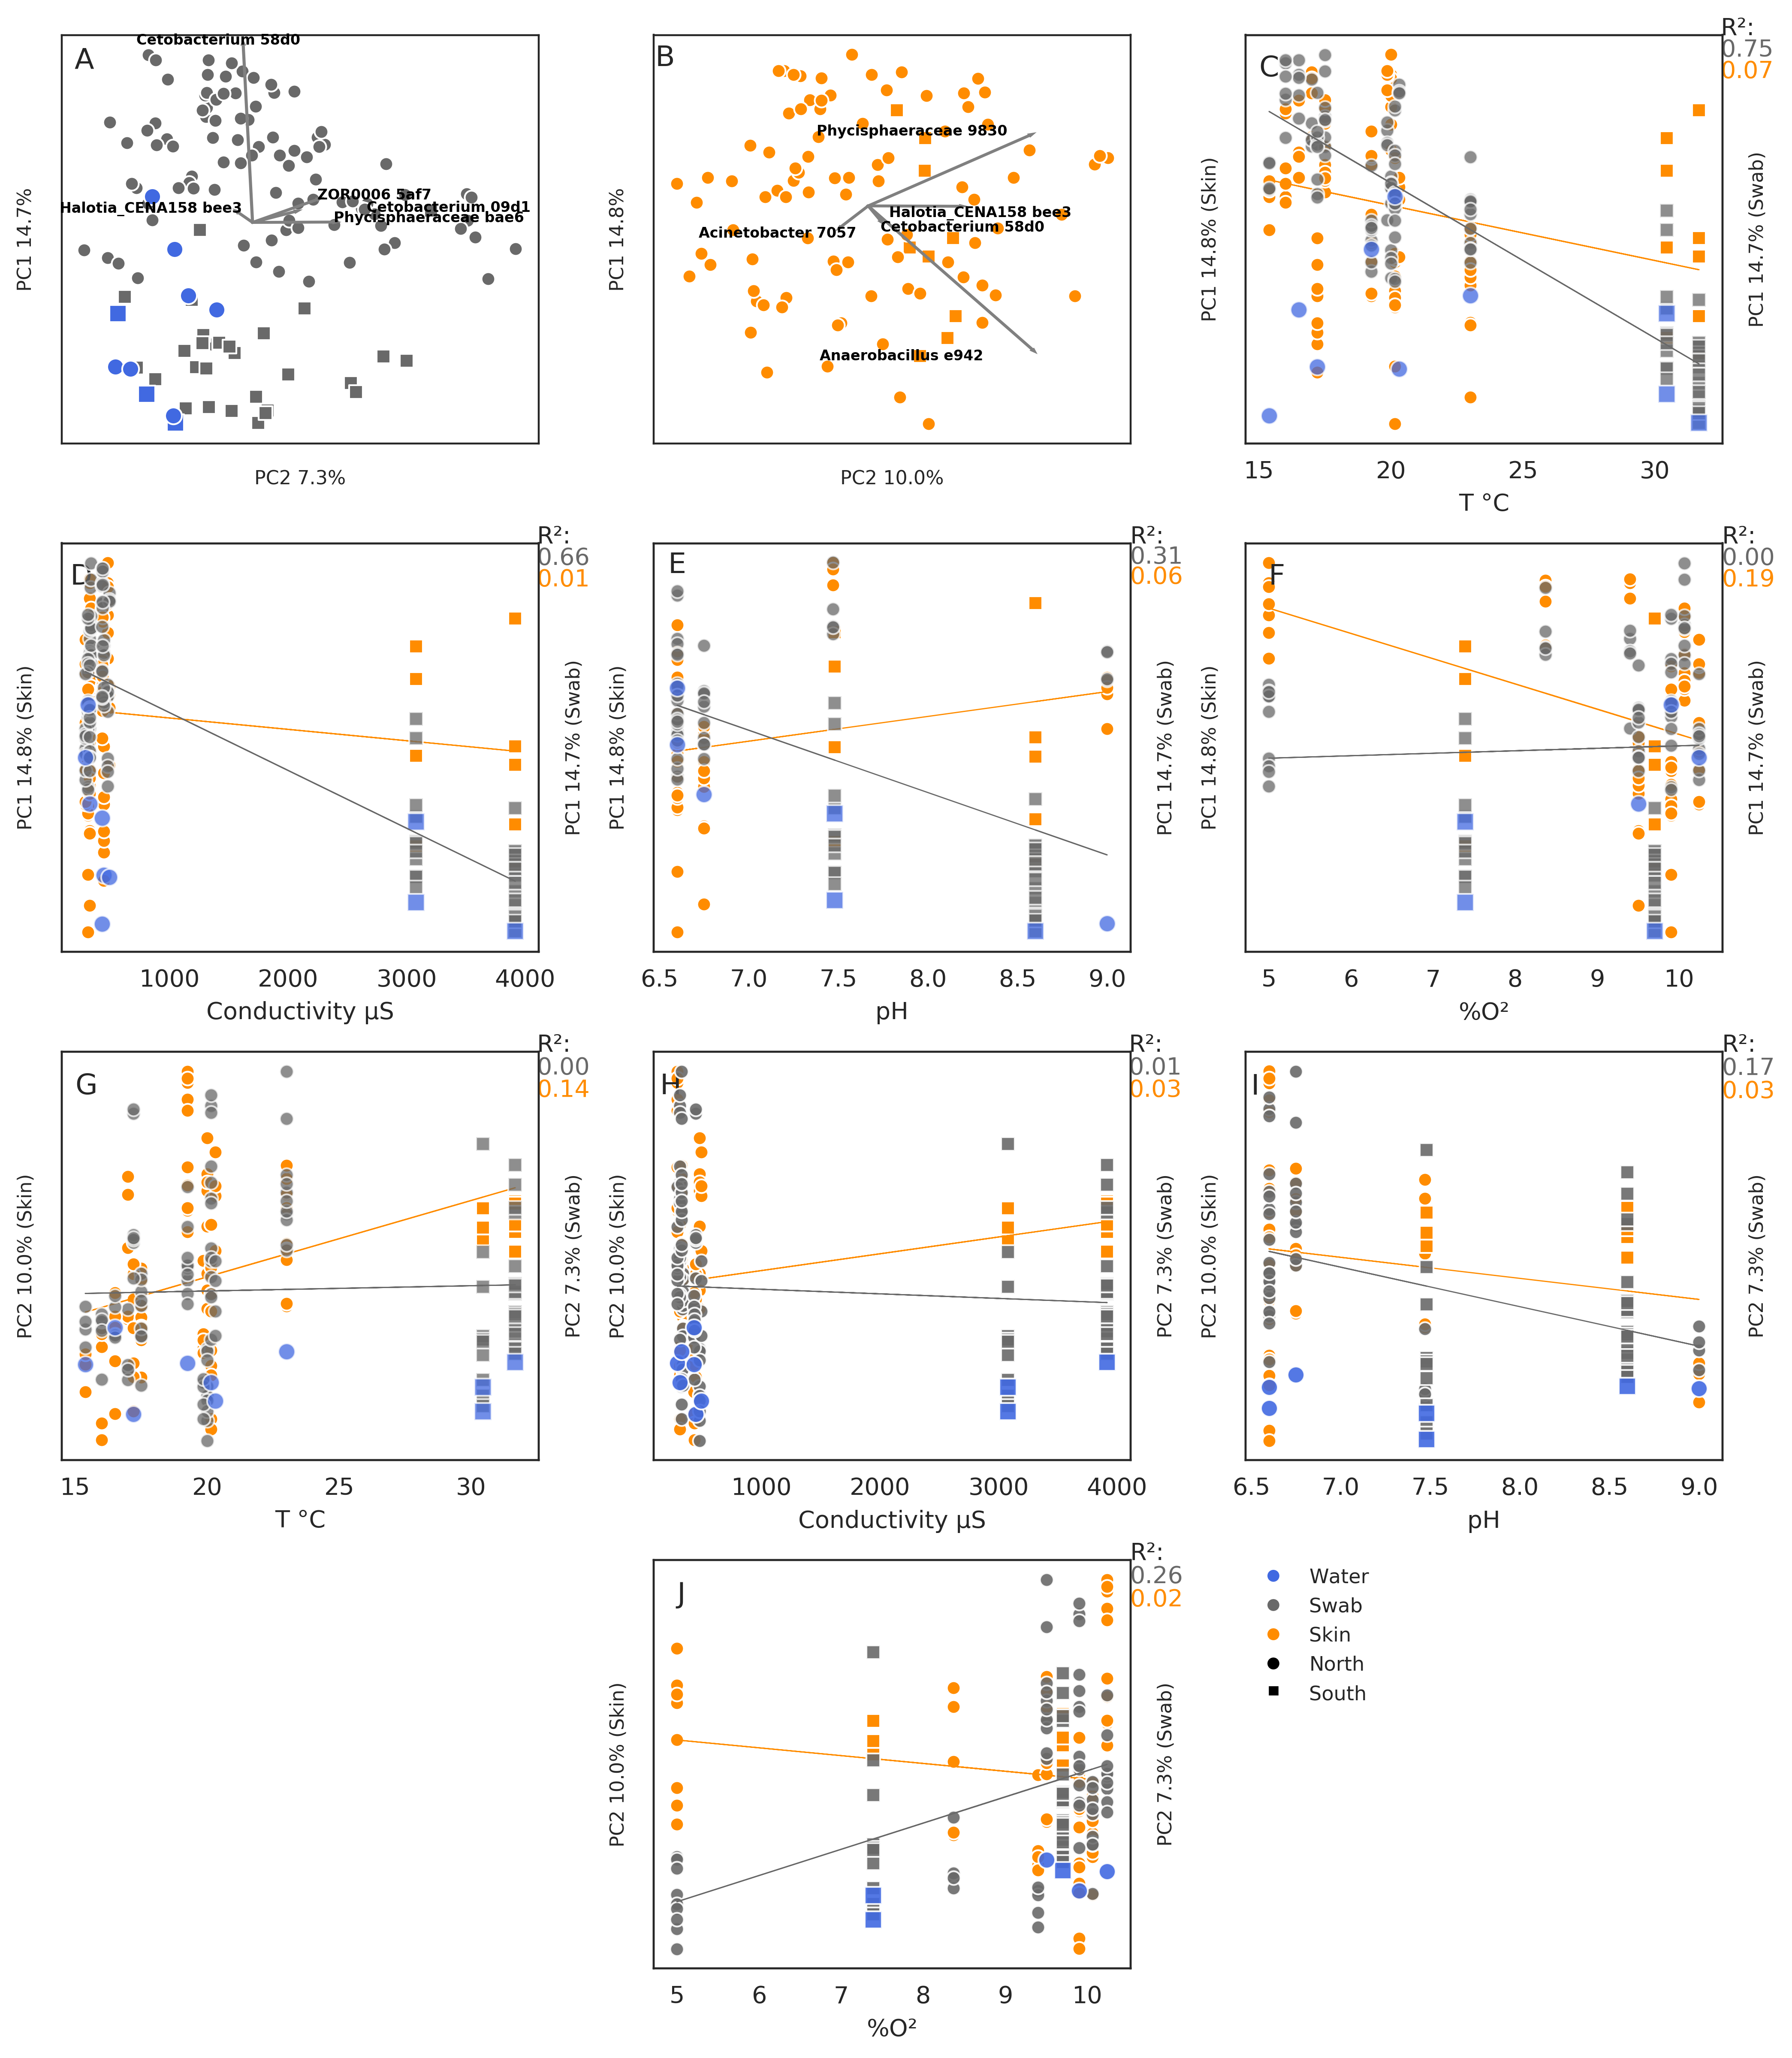

In [12]:
sns.set_style("white")

colors = {
    'Swab': 'dimgrey',
    'Water': 'royalblue'
    
}

markers = {
    'H': 'o',
    'J': 'o',
    'S': 'o',
    'T': 's',
    'A': 's'
}

sizes = {
    'H.0.1':33,#40,
    'H.0.2':33,#40,
    'H.0.4':33,#40,
    'H.0.5':33,#40,
    'H.0.6':33,#40,
    'H.1':33,#40,
    'J.1':33,#33,
    'J.2':33,#33,
    'J.3':33,#33,
    'J.4':33,#33,
    'S.1':33,#20,
    'S.2':33,#20,
    'S.3':33,#20,
    'A': 33,#33,
    'T.1': 33,#20,
    'T.2': 33,#20
}

class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Circle(xy=center,radius=2)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]
    
class HandlerSquare(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        corner = 0.42*width -  xdescent, 0.38*height - ydescent
        p = mpatches.Rectangle(corner,3,3)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def get_arrow_coords(xaxis,yaxis,num,biplot,taxa):
    arrow_data = []
    origin = np.zeros_like(biplot.columns)
    biplot['importance'] = biplot.apply(euclidean, axis=1, args=(origin,))
    biplot.index = biplot.index.astype(str)
    biplot.columns = biplot.columns.astype(str)

    biplot.sort_values('importance', inplace=True, ascending=False)
    for ind in biplot.index.tolist()[:num]:
        tax_line = taxa.at[ind,'Taxon'].split(';')
        taxon = tax_line.pop(-1)
        while taxon == 'NA' and tax_line:
            taxon = tax_line.pop(-1)
        taxon += ' ' + ind[-4:]
        arrow_data.append([taxon,biplot.at[str(ind),str(xaxis)],biplot.at[str(ind),str(yaxis)]])
    return arrow_data
        
qza = 'input_qza/dada_taxa.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/taxonomy.tsv'
taxa = pd.read_csv(inf,index_col=0,sep='\t')
!rm -r $digest    

data = regression.loc[:,['skin_axis_2','skin_axis_1','swab_axis_2',
                         'swab_axis_1','type','Sampling site','T',
                         'Conductivity  ','pH','PercentO']]

fig, axes = plt.subplots(ncols=3,nrows=4,figsize=(10.5,12), tight_layout=True,dpi=400)
        
ax = axes[0][0]

# A: swab PCoA

x='swab_axis_2'
y='swab_axis_1'

for sample_type in ['Swab','Water']:
    for loc in set(data['Sampling site']):
        color = colors[sample_type]
        marker = markers[loc[0]]
        size = sizes[loc]
        if sample_type == 'Water':
            size=50
        sns.scatterplot(x=x,
                        y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(),
                        ax=ax, 
                        legend=False, 
                        color=color,
                        marker=marker,
                        s=size) 
        
arrow_data = get_arrow_coords(2,1,5,swab_biplot,taxa)  

for arrow in arrow_data:
    ax.arrow(0, 0, arrow[1], arrow[2],fc='gray',ec='gray')
    text_x = arrow[1]
    if text_x < 0:
        text_x -= 0.15
    text =  arrow[0]
    if text.startswith('Halotia'):
        text_x -= 0.1
    if text.endswith('09d1'):
        text_x += 0.1
    ax.text(text_x, arrow[2],text,fontdict={'fontsize': 6, 'color':'black','weight':'bold'})
    
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_ylabel('PC%i %.1f%%' % (1, swab_Proportion[0]*100.0),fontdict={'fontsize': 8})
ax.set_xlabel('PC%i %.1f%%' % (2, swab_Proportion[1]*100.0),fontdict={'fontsize': 8})
ax.text(-0.25, 0.28,'A',fontdict={'fontsize': 12})


# B: Skin PCoA

ax = axes[0][1]

x='skin_axis_2'
y='skin_axis_1'
for sample_type in ['Swab']:
    for loc in set(data['Sampling site']):
        color = 'darkorange'
        marker = markers[loc[0]]
        size = sizes[loc]
        d = data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna()
        sns.scatterplot(x=x,
                        y=y,
                        data=d, 
                        ax=ax, 
                        legend=False, 
                        color=color,
                        marker=marker,
                        s=size) 
    
arrow_data = get_arrow_coords(2,1,5,skin_biplot,taxa)  

for arrow in arrow_data:
    ax.arrow(0, 0, arrow[1], arrow[2],fc='gray',ec='gray')
    text_x = arrow[1]
    text_y = arrow[2]
    if text_x < 0:
        text_x -= 0.2
    if text_x > 0 and len(arrow[0]) > 18:
        text_x -= 0.3
    if text_y < 0:
        text_y -= 0.02
    if arrow[0].startswith('Halotia'):
        text_x += 0.2
    if text_x < 0.7:
        ax.text(text_x, text_y, arrow[0],fontdict={'fontsize': 6, 'color':'black','weight':'bold'})
        
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_ylabel('PC%i %.1f%%' % (1, skin_Proportion[0]*100.0),fontdict={'fontsize': 8})
ax.set_xlabel('PC%i %.1f%%' % (2, skin_Proportion[1]*100.0),fontdict={'fontsize': 8})
ax.text(-0.30, 0.27,'B',fontdict={'fontsize': 12})


# C: axis 1 VS T

ax = axes[0][2]
ax2 = ax.twinx()

x = 'T'
y = 'skin_axis_1'
for sample_type in ['Swab']:
    for loc in set(data['Sampling site']):
        marker = markers[loc[0]]
        size = sizes[loc]
        sns.scatterplot(x=x,y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(),
                        ax=ax,
                        legend=False,
                        color='darkorange',
                        marker=marker,
                        s=size)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()        
ax.text(xmax,ymax,u'R\u00b2:')

d = data.loc[data['type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax.plot(d[x].values, line,color='darkorange',lw=0.5)
ax.text(xmax,ymax-2*(ymax/8),"%.2f"% (r_value*r_value),color='darkorange')

x = 'T'
y = 'swab_axis_1'
for sample_type in ['Swab','Water']:
    for loc in set(data['Sampling site']):
        color = colors[sample_type]
        marker = markers[loc[0]]
        size = sizes[loc]
        if sample_type == 'Water':
            size=50
            
        sns.scatterplot(x=x,y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(),
                        ax=ax2,
                        legend=False,
                        color=color,
                        marker=marker,
                        s=size,
                        alpha=0.75) 


d = data.loc[data['type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax2.plot(d[x].values, line,color='dimgrey',lw=0.5)
ax.text(xmax,ymax-(ymax/8),"%.2f"% (r_value*r_value),color='dimgrey')

ax2.set_ylabel('PC%i %.1f%% (Swab)' % (1, swab_Proportion[0]*100.0),fontdict={'fontsize': 8})
ax.set_ylabel('PC%i %.1f%% (Skin)' % (1, skin_Proportion[0]*100.0),fontdict={'fontsize': 8})
ax.set_xlabel(u'T \N{DEGREE SIGN}C')
ax.set_yticklabels([])
ax2.set_yticklabels([])
ax.yaxis.set_ticks_position('none') 
ax2.yaxis.set_ticks_position('none') 
ax.text(15, 0.25,'C',fontdict={'fontsize': 12})

# D: axis 1 VS Conductivity

ax = axes[1][0]
ax2 = ax.twinx()

x='Conductivity  '
y='skin_axis_1'

for sample_type in ['Swab']:
    for loc in set(data['Sampling site']):
        color = colors[sample_type]
        marker = markers[loc[0]]
        size = sizes[loc]
        sns.scatterplot(x=x,y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(), 
                        ax=ax, 
                        legend=False, 
                        color='darkorange',
                        marker=marker,
                        s=size) 
        
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()        
ax.text(xmax,ymax,u'R\u00b2:')

d = data.loc[data['type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax.plot(d[x].values, line,color='darkorange',lw=0.5)
ax.text(xmax,ymax-2*(ymax/8),"%.2f"% (r_value*r_value),color='darkorange')

x='Conductivity  '
y='swab_axis_1'
for sample_type in ['Swab','Water']:
    for loc in set(data['Sampling site']):
        color = colors[sample_type]
        marker = markers[loc[0]]
        size = sizes[loc]
        if sample_type == 'Water':
            size=50
        sns.scatterplot(x=x,y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(), 
                        ax=ax2, 
                        legend=False, 
                        color=color,
                        marker=marker,
                        s=size,
                        alpha=0.75) 

d = data.loc[data['type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax2.plot(d[x].values, line,color='dimgrey',lw=0.5)
ax.text(xmax,ymax-(ymax/8),"%.2f"% (r_value*r_value),color='dimgrey')

ax2.set_ylabel('PC%i %.1f%% (Swab)' % (1, swab_Proportion[0]*100.0),fontdict={'fontsize': 8})
ax.set_ylabel('PC%i %.1f%% (Skin)' % (1, skin_Proportion[0]*100.0),fontdict={'fontsize': 8})
ax.set_xlabel(u'Conductivity \N{Greek Small Letter Mu}S')
ax.set_yticklabels([])
ax2.set_yticklabels([])
ax.yaxis.set_ticks_position('none') 
ax2.yaxis.set_ticks_position('none')
ax.text(160, 0.25,'D',fontdict={'fontsize': 12})

# E: axis 1 VS pH

ax = axes[1,1]
ax2 = ax.twinx()


x='pH'
y='skin_axis_1'

for sample_type in ['Swab']:
    for loc in set(data['Sampling site']):
        color = colors[sample_type]
        marker = markers[loc[0]]
        size = sizes[loc]
        sns.scatterplot(x=x,y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(), 
                        ax=ax, 
                        legend=False, 
                        color='darkorange',
                        marker=marker,
                        s=size) 
        
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()        
ax.text(xmax,ymax,u'R\u00b2:')

d = data.loc[data['type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax.plot(d[x].values, line,color='darkorange',lw=0.5)
ax.text(xmax,ymax-2*(ymax/8),"%.2f"% (r_value*r_value),color='darkorange')


x='pH'
y='swab_axis_1'
for sample_type in ['Swab','Water']:
    for loc in set(data['Sampling site']):
        color = colors[sample_type]
        marker = markers[loc[0]]
        size = sizes[loc]
        if sample_type == 'Water':
            size=50
        sns.scatterplot(x=x,y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(), 
                        ax=ax2, 
                        legend=False, 
                        color=color,
                        marker=marker,
                        s=size,
                        alpha=0.75)  

d = data.loc[data['type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax2.plot(d[x].values, line,color='dimgrey',lw=0.5)
ax.text(xmax,ymax-(ymax/8),"%.2f"% (r_value*r_value),color='dimgray')

ax2.set_ylabel('PC%i %.1f%% (Swab)' % (1, swab_Proportion[0]*100.0),fontdict={'fontsize': 8})
ax.set_ylabel('PC%i %.1f%% (Skin)' % (1, skin_Proportion[0]*100.0),fontdict={'fontsize': 8})
ax.set_xlabel(u'pH')
ax.set_yticklabels([])
ax2.set_yticklabels([])
ax.yaxis.set_ticks_position('none') 
ax2.yaxis.set_ticks_position('none')
ax.text(6.55,0.24,'E',fontdict={'fontsize': 12})

# F: axis 1 VS PercentO

ax = axes[1,2]
ax2 = ax.twinx()

x='PercentO'
y='skin_axis_1'

for sample_type in ['Swab']:
    for loc in set(data['Sampling site']):
        color = colors[sample_type]
        marker = markers[loc[0]]
        size = sizes[loc]
        sns.scatterplot(x=x,y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(), 
                        ax=ax, 
                        legend=False, 
                        color='darkorange',
                        marker=marker,
                        s=size) 
        
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()        
ax.text(xmax,ymax,u'R\u00b2:')
        
d = data.loc[data['type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax.plot(d[x].values, line,color='darkorange',lw=0.5)
ax.text(xmax,ymax-2*(ymax/8),"%.2f"% (r_value*r_value),color='darkorange')

x='PercentO'
y='swab_axis_1'
for sample_type in ['Swab','Water']:
    for loc in set(data['Sampling site']):
        color = colors[sample_type]
        marker = markers[loc[0]]
        size = sizes[loc]
        if sample_type == 'Water':
            size=50
        sns.scatterplot(x=x,y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(), 
                        ax=ax2, 
                        legend=False, 
                        color=color,
                        marker=marker,
                        s=size,
                        alpha=0.75) 
        
d = data.loc[data['type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax2.plot(d[x].values, line,color='dimgray',lw=0.5)
ax.text(xmax,ymax-(ymax/8),"%.2f"% (r_value*r_value),color='dimgray')


ax2.set_ylabel('PC%i %.1f%% (Swab)' % (1, swab_Proportion[0]*100.0),fontdict={'fontsize': 8})
ax.set_ylabel('PC%i %.1f%% (Skin)' % (1, skin_Proportion[0]*100.0),fontdict={'fontsize': 8})
ax.set_xlabel(u'%O\u00b2')
ax.set_yticklabels([])
ax2.set_yticklabels([])
ax.yaxis.set_ticks_position('none') 
ax2.yaxis.set_ticks_position('none')
ax.text(5, 0.25,'F',fontdict={'fontsize': 12})

# G: axis 2 VS T

ax = axes[2][0]
ax2 = ax.twinx()

x = 'T'
y = 'skin_axis_2'

for sample_type in ['Swab']:
    for loc in set(data['Sampling site']):
        marker = markers[loc[0]]
        size = sizes[loc]
        sns.scatterplot(x=x,y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(),
                        ax=ax,
                        legend=False,
                        color='darkorange',
                        marker=marker,
                        s=size)  
        
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()        
ax.text(xmax,ymax,u'R\u00b2:')

d = data.loc[data['type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax.plot(d[x].values, line,color='darkorange',lw=0.5)
ax.text(xmax,ymax-2*(ymax/10),"%.2f"% (r_value*r_value),color='darkorange')

x = 'T'
y = 'swab_axis_2'
for sample_type in ['Swab','Water']:
    for loc in set(data['Sampling site']):
        color = colors[sample_type]
        marker = markers[loc[0]]
        size = sizes[loc]
        if sample_type == 'Water':
            size=50
        sns.scatterplot(x=x,y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(),
                        ax=ax2,
                        legend=False,
                        color=color,
                        marker=marker,
                        s=size,
                        alpha=0.75)
        
d = data.loc[data['type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax2.plot(d[x].values, line,color='dimgray',lw=0.5)
ax.text(xmax,ymax-(ymax/10),"%.2f"% (r_value*r_value),color='dimgray')


ax2.set_ylabel('PC%i %.1f%% (Swab)' % (2, swab_Proportion[1]*100.0),fontdict={'fontsize': 8})
ax.set_ylabel('PC%i %.1f%% (Skin)' % (2, skin_Proportion[1]*100.0),fontdict={'fontsize': 8})
ax.set_xlabel(u'T \N{DEGREE SIGN}C')
ax.set_yticklabels([])
ax2.set_yticklabels([])
ax.yaxis.set_ticks_position('none') 
ax2.yaxis.set_ticks_position('none')
ax.text(15, 0.3,'G',fontdict={'fontsize': 12})

# H: axis 2 VS Conductivity

ax = axes[2][1]
ax2 = ax.twinx()

x='Conductivity  '
y='skin_axis_2'

for sample_type in ['Swab']:
    for loc in set(data['Sampling site']):
        color = colors[sample_type]
        marker = markers[loc[0]]
        size = sizes[loc]
        sns.scatterplot(x=x,y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(), 
                        ax=ax, 
                        legend=False, 
                        color='darkorange',
                        marker=marker,
                        s=size) 
        
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()        
ax.text(xmax,ymax,u'R\u00b2:')

d = data.loc[data['type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax.plot(d[x].values, line,color='darkorange',lw=0.5)
ax.text(xmax,ymax-2*(ymax/10),"%.2f"% (r_value*r_value),color='darkorange')

x='Conductivity  '
y='swab_axis_2'
for sample_type in ['Swab','Water']:
    for loc in set(data['Sampling site']):
        color = colors[sample_type]
        marker = markers[loc[0]]
        size = sizes[loc]
        if sample_type == 'Water':
            size=50
        sns.scatterplot(x=x,y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(), 
                        ax=ax2, 
                        legend=False, 
                        color=color,
                        marker=marker,
                        s=size,
                        alpha=0.9)

d = data.loc[data['type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax2.plot(d[x].values, line,color='dimgray',lw=0.5)
ax.text(xmax,ymax-(ymax/10),"%.2f"% (r_value*r_value),color='dimgray')

ax2.set_ylabel('PC%i %.1f%% (Swab)' % (2, swab_Proportion[1]*100.0),fontdict={'fontsize': 8})
ax.set_ylabel('PC%i %.1f%% (Skin)' % (2, skin_Proportion[1]*100.0),fontdict={'fontsize': 8})
ax.set_xlabel(u'Conductivity \N{Greek Small Letter Mu}S')
ax.set_yticklabels([])
ax2.set_yticklabels([])
ax.yaxis.set_ticks_position('none') 
ax2.yaxis.set_ticks_position('none')
ax.text(140, 0.3,'H',fontdict={'fontsize': 12})

# I: axis 2 VS pH

ax = axes[2,2]
ax2 = ax.twinx()

x='pH'
y='skin_axis_2'

for sample_type in ['Swab']:
    for loc in set(data['Sampling site']):
        color = colors[sample_type]
        marker = markers[loc[0]]
        size = sizes[loc]
        sns.scatterplot(x=x,y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(), 
                        ax=ax, 
                        legend=False, 
                        color='darkorange',
                        marker=marker,
                        s=size) 
        
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()        
ax.text(xmax,ymax,u'R\u00b2:')

d = data.loc[data['type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax.plot(d[x].values, line,color='darkorange',lw=0.5)
ax.text(xmax,ymax-2*(ymax/10),"%.2f"% (r_value*r_value),color='darkorange')

x='pH'
y='swab_axis_2'
for sample_type in ['Swab','Water']:
    for loc in set(data['Sampling site']):
        color = colors[sample_type]
        marker = markers[loc[0]]
        size = sizes[loc]
        if sample_type == 'Water':
            size=50
        sns.scatterplot(x=x,y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(), 
                        ax=ax2, 
                        legend=False, 
                        color=color,
                        marker=marker,
                        s=size,
                        alpha=0.9)
        
d = data.loc[data['type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax2.plot(d[x].values, line,color='dimgray',lw=0.5)
ax.text(xmax,ymax-(ymax/10),"%.2f"% (r_value*r_value),color='dimgray')

ax2.set_ylabel('PC%i %.1f%% (Swab)' % (2, swab_Proportion[1]*100.0),fontdict={'fontsize': 8})
ax.set_ylabel('PC%i %.1f%% (Skin)' % (2, skin_Proportion[1]*100.0),fontdict={'fontsize': 8})
ax.set_xlabel(u'pH')
ax.set_yticklabels([])
ax2.set_yticklabels([])
ax.yaxis.set_ticks_position('none') 
ax2.yaxis.set_ticks_position('none')
ax.text(6.5, 0.3,'I',fontdict={'fontsize': 12})

ax = axes[3,0]
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# J: axis 2 VS PercentO

ax = axes[3,1]
ax2 = ax.twinx()

x='PercentO'
y='skin_axis_2'

for sample_type in ['Swab']:
    for loc in set(data['Sampling site']):
        color = colors[sample_type]
        marker = markers[loc[0]]
        size = sizes[loc]
        sns.scatterplot(x=x,y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(), 
                        ax=ax, 
                        legend=False, 
                        color='darkorange',
                        marker=marker,
                        s=size) 
        
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()        
ax.text(xmax,ymax,u'R\u00b2:') 

d = data.loc[data['type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax.plot(d[x].values, line,color='darkorange',lw=0.5)
ax.text(xmax,ymax-2*(ymax/10),"%.2f"% (r_value*r_value),color='darkorange')

x='PercentO'
y='swab_axis_2'
for sample_type in ['Swab','Water']:
    for loc in set(data['Sampling site']):
        color = colors[sample_type]
        marker = markers[loc[0]]
        size = sizes[loc]
        if sample_type == 'Water':
            size=50
        sns.scatterplot(x=x,y=y,
                        data=data.loc[((data['type']==sample_type) & (data['Sampling site']==loc)),[x,y]].dropna(), 
                        ax=ax2, 
                        legend=False, 
                        color=color,
                        marker=marker,
                        s=size,
                        alpha=0.9)

d = data.loc[data['type'] == 'Swab',[x,y]].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(d[x].values,d[y].tolist())
line = slope*d[x].values+intercept
ax2.plot(d[x].values, line,color='dimgray',lw=0.5)
ax.text(xmax,ymax-(ymax/10),"%.2f"% (r_value*r_value),color='dimgray')

ax2.set_ylabel('PC%i %.1f%% (Swab)' % (2, swab_Proportion[1]*100.0),fontdict={'fontsize': 8})
ax.set_ylabel('PC%i %.1f%% (Skin)' % (2, skin_Proportion[1]*100.0),fontdict={'fontsize': 8})
ax.set_xlabel(u'%O\u00b2')
ax.set_yticklabels([])
ax2.set_yticklabels([])
ax.yaxis.set_ticks_position('none') 
ax2.yaxis.set_ticks_position('none')
a=ax.text(5, 0.3,'J',fontdict={'fontsize': 12})

ax = axes[3,2]
handles, labels = ([],[])
for color in ['royalblue','dimgrey','darkorange','black']:
    handles += [mpatches.Circle([0.5,0.5],0.25,color=color)]
handles += [mpatches.Patch([0.5,0.5],0.25,color='black')]
labels += ['Water','Swab','Skin','North','South']
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.legend(handles, 
          labels,
          #bbox_to_anchor=(1, 1),
          loc=2, 
          borderaxespad=0.,
          fontsize='small',
          frameon=False,
          handler_map={mpatches.Circle: HandlerCircle(),mpatches.Patch: HandlerSquare()}) 
plt.savefig('Figures/beta_diversity.png',bbox_inches='tight')

#### Create North and South swab and skin distance matrices, PCoA and BiPlots

In [70]:
%%bash

source activate qiime2-2019.4


# North

qiime diversity core-metrics-phylogenetic \
  --i-table input_qza/dada_table.no_water_or_ntc_N.min2.qza \
  --i-phylogeny input_qza/rooted-tree.qza \
  --p-sampling-depth 899 \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --output-dir diversity-North

qiime feature-table relative-frequency \
 --i-table input_qza/dada_table.no_water_or_ntc_N.min2.qza \
 --o-relative-frequency-table temp.qza 

qiime diversity pcoa-biplot \
  --i-pcoa diversity-North/unweighted_unifrac_pcoa_results.qza \
  --i-features temp.qza \
  --o-biplot diversity-North/unweighted_unifrac_pcoa_results_biplot.qza

rm temp.qza

# South

qiime diversity core-metrics-phylogenetic \
  --i-table input_qza/dada_table.no_water_or_ntc_S.min2.qza \
  --i-phylogeny input_qza/rooted-tree.qza \
  --p-sampling-depth 899 \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --output-dir diversity-South

qiime feature-table relative-frequency \
 --i-table input_qza/dada_table.no_water_or_ntc_S.min2.qza \
 --o-relative-frequency-table temp.qza 

qiime diversity pcoa-biplot \
  --i-pcoa diversity-South/unweighted_unifrac_pcoa_results.qza \
  --i-features temp.qza \
  --o-biplot diversity-South/unweighted_unifrac_pcoa_results_biplot.qza

rm temp.qza

Saved FeatureTable[Frequency] to: diversity-North/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: diversity-North/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: diversity-North/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: diversity-North/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: diversity-North/evenness_vector.qza
Saved DistanceMatrix % Properties('phylogenetic') to: diversity-North/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties('phylogenetic') to: diversity-North/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: diversity-North/jaccard_distance_matrix.qza
Saved DistanceMatrix to: diversity-North/bray_curtis_distance_matrix.qza
Saved PCoAResults to: diversity-North/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: diversity-North/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: diversity-North/jaccard_pcoa_results.qza
Saved PCoAResults to: diversity-North/b

In [71]:
%%bash

source activate qiime2-2019.4

# Separate for N and S basins for denoised skin table
qiime feature-table filter-samples \
  --i-table denoised_tables/skin_microbiome.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --p-where "Basin IN ('N')" \
  --p-min-frequency 499 \
  --o-filtered-table denoised_tables/skin_microbiome_N.qza

qiime feature-table filter-samples \
  --i-table denoised_tables/skin_microbiome.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --p-where "Basin IN ('S')" \
  --p-min-frequency 499 \
  --o-filtered-table denoised_tables/skin_microbiome_S.qza

# Skin North

qiime diversity core-metrics-phylogenetic \
  --i-table denoised_tables/skin_microbiome_N.qza \
  --i-phylogeny input_qza/rooted-tree.qza \
  --p-sampling-depth 500 \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --output-dir diversity-skin-North

qiime feature-table relative-frequency \
 --i-table denoised_tables/skin_microbiome_N.qza \
 --o-relative-frequency-table temp.qza 

qiime diversity pcoa-biplot \
  --i-pcoa diversity-skin-North/unweighted_unifrac_pcoa_results.qza \
  --i-features temp.qza \
  --o-biplot diversity-skin-North/unweighted_unifrac_pcoa_results_biplot.qza

rm temp.qza

# Skin South

qiime diversity core-metrics-phylogenetic \
  --i-table denoised_tables/skin_microbiome_S.qza \
  --i-phylogeny input_qza/rooted-tree.qza \
  --p-sampling-depth 500 \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --output-dir diversity-skin-South

qiime feature-table relative-frequency \
 --i-table denoised_tables/skin_microbiome_S.qza \
 --o-relative-frequency-table temp.qza 

qiime diversity pcoa-biplot \
  --i-pcoa diversity-skin-South/unweighted_unifrac_pcoa_results.qza \
  --i-features temp.qza \
  --o-biplot diversity-skin-South/unweighted_unifrac_pcoa_results_biplot.qza

rm temp.qza

Saved FeatureTable[Frequency] to: denoised_tables/skin_microbiome_N.qza
Saved FeatureTable[Frequency] to: denoised_tables/skin_microbiome_S.qza
Saved FeatureTable[Frequency] to: diversity-skin-North/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: diversity-skin-North/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: diversity-skin-North/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: diversity-skin-North/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: diversity-skin-North/evenness_vector.qza
Saved DistanceMatrix % Properties('phylogenetic') to: diversity-skin-North/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties('phylogenetic') to: diversity-skin-North/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: diversity-skin-North/jaccard_distance_matrix.qza
Saved DistanceMatrix to: diversity-skin-North/bray_curtis_distance_matrix.qza
Saved PCoAResults to: diversity-skin-North/unweighted_unifr

/home/amir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/home/amir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  
/home/amir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


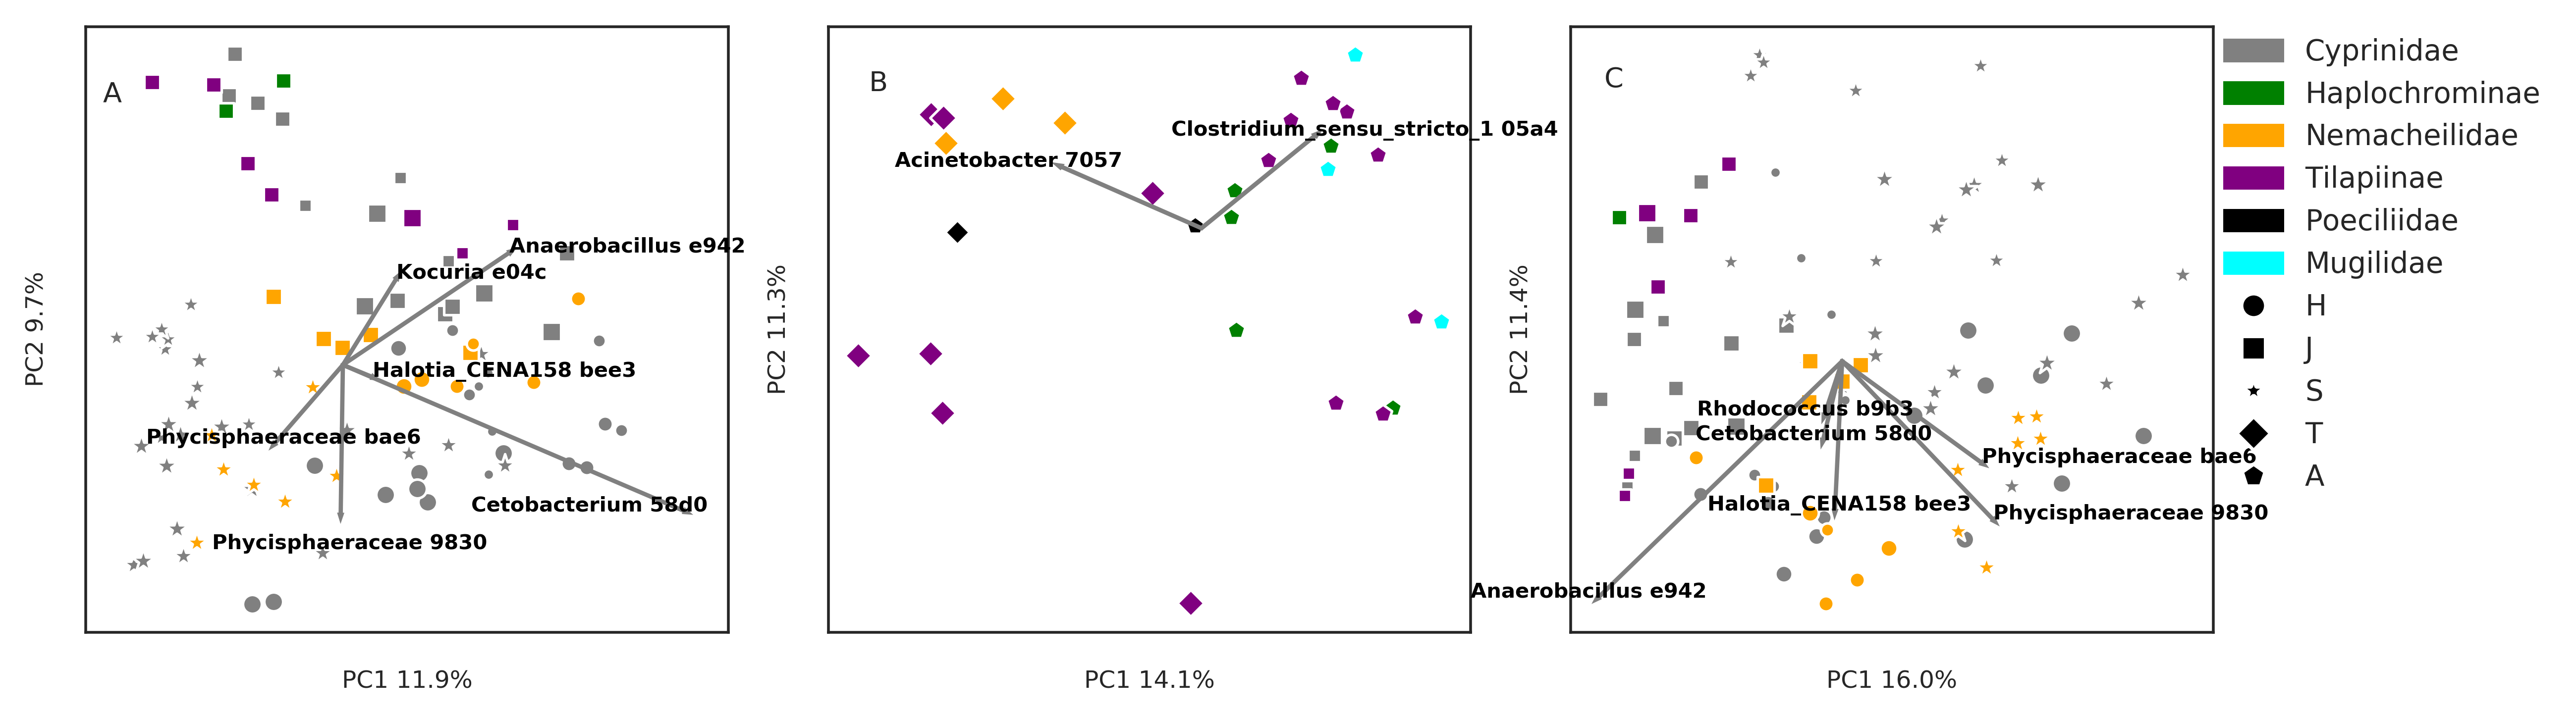

In [85]:
sns.set_style("white")

colors = {
    'Cyprinidae': 'gray',
    'Haplochrominae': 'green',
    'Nemacheilidae': 'orange',
    'Tilapiinae': 'purple',
    'Poeciliidae': 'Black',
    'Mugilidae': 'Cyan'
    
}

markers = {
    'H': 'o',
    'J': 's',
    'S': '*',
    'T': 'D',
    'A': 'p'
}

sizes = {
    'H.0.1':25,
    'H.0.2':20,
    'H.0.4':15,
    'H.0.5':10,
    'H.0.6':10,
    'H.1':30,
    'J.1':30,
    'J.2':25,
    'J.3':20,
    'J.4':15,
    'S.1':50,
    'S.2':45,
    'S.3':40,
    'A': 30,
    'T.1': 25,
    'T.2': 30
}

qza = 'input_qza/dada_taxa.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/taxonomy.tsv'
taxa = pd.read_table(inf,index_col=0)
!rm -r $digest     

fig, axes = plt.subplots(ncols=3,figsize=(10.5,3), tight_layout=True,dpi=500)

ax0 = axes[0]

qza = 'diversity-North/unweighted_unifrac_pcoa_results_biplot.qza'

ordination, biplot, Eigvals, Proportion = parse_biplot(qza)

pca_metadata = regression_no_water.loc[regression_no_water.index.isin(ordination.index)]

x=1
y=2
for fam in set(pca_metadata.family_or_tribe):
    for loc in set(pca_metadata['Sampling site']):
        color = colors[fam]
        marker = markers[loc[0]]
        size = sizes[loc]
        data = ordination.loc[ordination.index.isin(pca_metadata.loc[((pca_metadata.family_or_tribe == fam) & 
                                                        (pca_metadata['Sampling site'] == loc))].index)]
        
        sns.scatterplot(x=x,y=y,data=data, ax=ax0, legend=False, color=color,marker=marker,s=size) 
        
ax0_arrow_data = get_arrow_coords(x,y,6,biplot,taxa)  
        
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.set_xlim(-0.3,0.45)
ax0.set_ylabel('PC%i %.1f%%' % (y, Proportion[1]*100.0),fontdict={'fontsize': 7})
ax0.set_xlabel('PC%i %.1f%%' % (x, Proportion[0]*100.0),fontdict={'fontsize': 7})
ax0.text(-0.28, 0.3,'A',fontdict={'fontsize': 8})

ax1 = axes[1]

qza = 'diversity-South/unweighted_unifrac_pcoa_results_biplot.qza'

ordination, biplot, Eigvals, Proportion = parse_biplot(qza)

pca_metadata = regression_no_water.loc[regression_no_water.index.isin(ordination.index)]
x=1
y=2

for fam in set(pca_metadata.family_or_tribe):
    for loc in set(pca_metadata['Sampling site']):
        color = colors[fam]
        marker = markers[loc[0]]
        size = sizes[loc]
        data = ordination.loc[ordination.index.isin(pca_metadata.loc[((pca_metadata.family_or_tribe == fam) & 
                                                        (pca_metadata['Sampling site'] == loc))].index)]
        sns.scatterplot(x=1,y=2,data=data, ax=ax1, legend=False, color=color,marker=marker,s=size) 
        
ax1_arrow_data = get_arrow_coords(x,y,2,biplot,taxa)  
    
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_ylabel('PC%i %.1f%%' % (y, Proportion[1]*100.0),fontdict={'fontsize': 7})
ax1.set_xlabel('PC%i %.1f%%' % (x, Proportion[0]*100.0),fontdict={'fontsize': 7})
ax1.text(-0.3, 0.15,'B',fontdict={'fontsize': 8})


ax2 = axes[2]

qza = 'diversity-skin-North/unweighted_unifrac_pcoa_results_biplot.qza'

ordination, biplot, Eigvals, Proportion = parse_biplot(qza)

pca_metadata = regression_no_water.loc[regression_no_water.index.isin(ordination.index)]

x=1
y=2
for fam in set(pca_metadata.family_or_tribe):
    for loc in set(pca_metadata['Sampling site']):
        color = colors[fam]
        marker = markers[loc[0]]
        size = sizes[loc]
        data = ordination.loc[ordination.index.isin(pca_metadata.loc[((pca_metadata.family_or_tribe == fam) & 
                                                        (pca_metadata['Sampling site'] == loc))].index)]
        
        sns.scatterplot(x=x,y=y,data=data, ax=ax2, legend=False, color=color,marker=marker,s=size) 
        
ax2_arrow_data = get_arrow_coords(x,y,6,biplot,taxa)  
       
ax2.set_xticklabels([])
ax2.set_yticklabels([])
#ax.set_xlim(-0.3,0.45)
ax2.set_ylabel('PC%i %.1f%%' % (y, Proportion[1]*100.0),fontdict={'fontsize': 7})
ax2.set_xlabel('PC%i %.1f%%' % (x, Proportion[0]*100.0),fontdict={'fontsize': 7})
ax2.text(-0.28, 0.3,'C',fontdict={'fontsize': 8})

for arrow in ax2_arrow_data:
    ax2.arrow(0, 0, arrow[1], arrow[2],fc='gray',ec='gray')
    text_x = arrow[1]
    if text_x < 0:
        text_x -= 0.15
    ax2.text(text_x, arrow[2], arrow[0],fontdict={'fontsize': 6, 'color':'black','weight':'bold'})

for arrow in ax1_arrow_data:
    ax1.arrow(0, 0, arrow[1], arrow[2],fc='gray',ec='gray')
    text_x = arrow[1]
    text_y = arrow[2]
    if text_x < 0:
        text_x -= 0.15
    if text_y > 0.07:
        text_x -= 0.13
    ax1.text(text_x, text_y, arrow[0],fontdict={'fontsize': 6, 'color':'black','weight':'bold'})

for arrow in ax0_arrow_data:
    ax0.arrow(0, 0, arrow[1], arrow[2],fc='gray',ec='gray')
    text_x = arrow[1]
    text_y = arrow[2]
    if text_x < 0:
        text_x -= 0.15
    elif text_x > 0.3:
        text_x = 0.15
    if text_y < -0.17:
        text_y = -0.21
    ax0.text(text_x, text_y, arrow[0],fontdict={'fontsize': 6, 'color':'black','weight':'bold'})

handles, labels = ([],[])

for color in ['gray','green','orange','purple','Black','Cyan']:
    handles += [mpatches.Patch([0.5,0.5],0.25,color=color)]
labels += ['Cyprinidae','Haplochrominae','Nemacheilidae','Tilapiinae','Poeciliidae','Mugilidae']

for m in 'os*Dp':
    handles += [Line2D([0], [0], marker=m,color='w',markerfacecolor='black',markersize=7)]

labels += ['H','J','S','T','A']


ax2.legend(handles, 
          labels,
          bbox_to_anchor=(1, 1),
          loc=2, 
          borderaxespad=0.,
          fontsize='small',
          frameon=False) 

fig.savefig('Figures/beta_diversity_families.png',bbox_inches='tight')

## ANCOM test, Nemacheilidae VS Tilapiinae

#### Swabs

In [ ]:
%%bash

source activate qiime2-2019.4

mkdir ancom_Nemacheilidae_Tilapiinae

qiime feature-table filter-samples \
  --i-table input_qza/dada_table.no_water_or_ntc.min2.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --p-where "family_or_tribe IN ('Nemacheilidae','Tilapiinae')" \
  --p-min-frequency 1000 \
  --o-filtered-table ancom_Nemacheilidae_Tilapiinae/table.qza

qiime composition add-pseudocount \
  --i-table ancom_Nemacheilidae_Tilapiinae/table.qza \
  --o-composition-table ancom_Nemacheilidae_Tilapiinae/comp-table.qza

qiime composition ancom \
  --i-table ancom_Nemacheilidae_Tilapiinae/comp-table.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --m-metadata-column family_or_tribe \
  --o-visualization ancom_Nemacheilidae_Tilapiinae/ancom.qzv

#### Print differentiating ASVs

In [10]:
qza = 'input_qza/dada_taxa.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/taxonomy.tsv'
taxa = pd.read_csv(inf,index_col=0,sep='\t')
!rm -r $digest

qza = 'ancom_Nemacheilidae_Tilapiinae/ancom.qzv'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/ancom.tsv'
ancom = pd.read_csv(inf,index_col=0,sep='\t')
!rm -r $digest

for ind, row in ancom.loc[ancom['Reject null hypothesis'] == True].iterrows():
    print ind, taxa.at[ind,'Taxon']

4ef1bb79af07907821f721c120cb0cb4 Bacteria;Firmicutes;Bacilli;Bacillales;Family_XII;Exiguobacterium


#### Denoised skin

In [49]:
%%bash

source activate qiime2-2019.4

mkdir ancom_Nemacheilidae_Tilapiinae_skin

qiime feature-table filter-samples \
  --i-table denoised_tables/skin_microbiome.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --p-where "family_or_tribe IN ('Nemacheilidae','Tilapiinae')" \
  --p-min-frequency 1000 \
  --o-filtered-table ancom_Nemacheilidae_Tilapiinae_skin/table.qza

qiime composition add-pseudocount \
  --i-table ancom_Nemacheilidae_Tilapiinae_skin/table.qza \
  --o-composition-table ancom_Nemacheilidae_Tilapiinae_skin/comp-table.qza

qiime composition ancom \
  --i-table ancom_Nemacheilidae_Tilapiinae_skin/comp-table.qza \
  --m-metadata-file fish_samples_metadata_loc_code_correct_sp.tsv \
  --m-metadata-column family_or_tribe \
  --o-visualization ancom_Nemacheilidae_Tilapiinae_skin/ancom.qzv

Saved FeatureTable[Frequency] to: ancom_Nemacheilidae_Tilapiinae_skin/table.qza
Saved FeatureTable[Composition] to: ancom_Nemacheilidae_Tilapiinae_skin/comp-table.qza
Saved Visualization to: ancom_Nemacheilidae_Tilapiinae_skin/ancom.qzv


In [50]:
qza = 'input_qza/dada_taxa.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/taxonomy.tsv'
taxa = pd.read_csv(inf,index_col=0,sep='\t')
!rm -r $digest

qza = 'ancom_Nemacheilidae_Tilapiinae_skin/ancom.qzv'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/ancom.tsv'
ancom = pd.read_csv(inf,index_col=0,sep='\t')
!rm -r $digest

for ind, row in ancom.loc[ancom['Reject null hypothesis'] == True].iterrows():
    print ind, taxa.at[ind,'Taxon']

4ef1bb79af07907821f721c120cb0cb4 Bacteria;Firmicutes;Bacilli;Bacillales;Family_XII;Exiguobacterium


## P B ratio

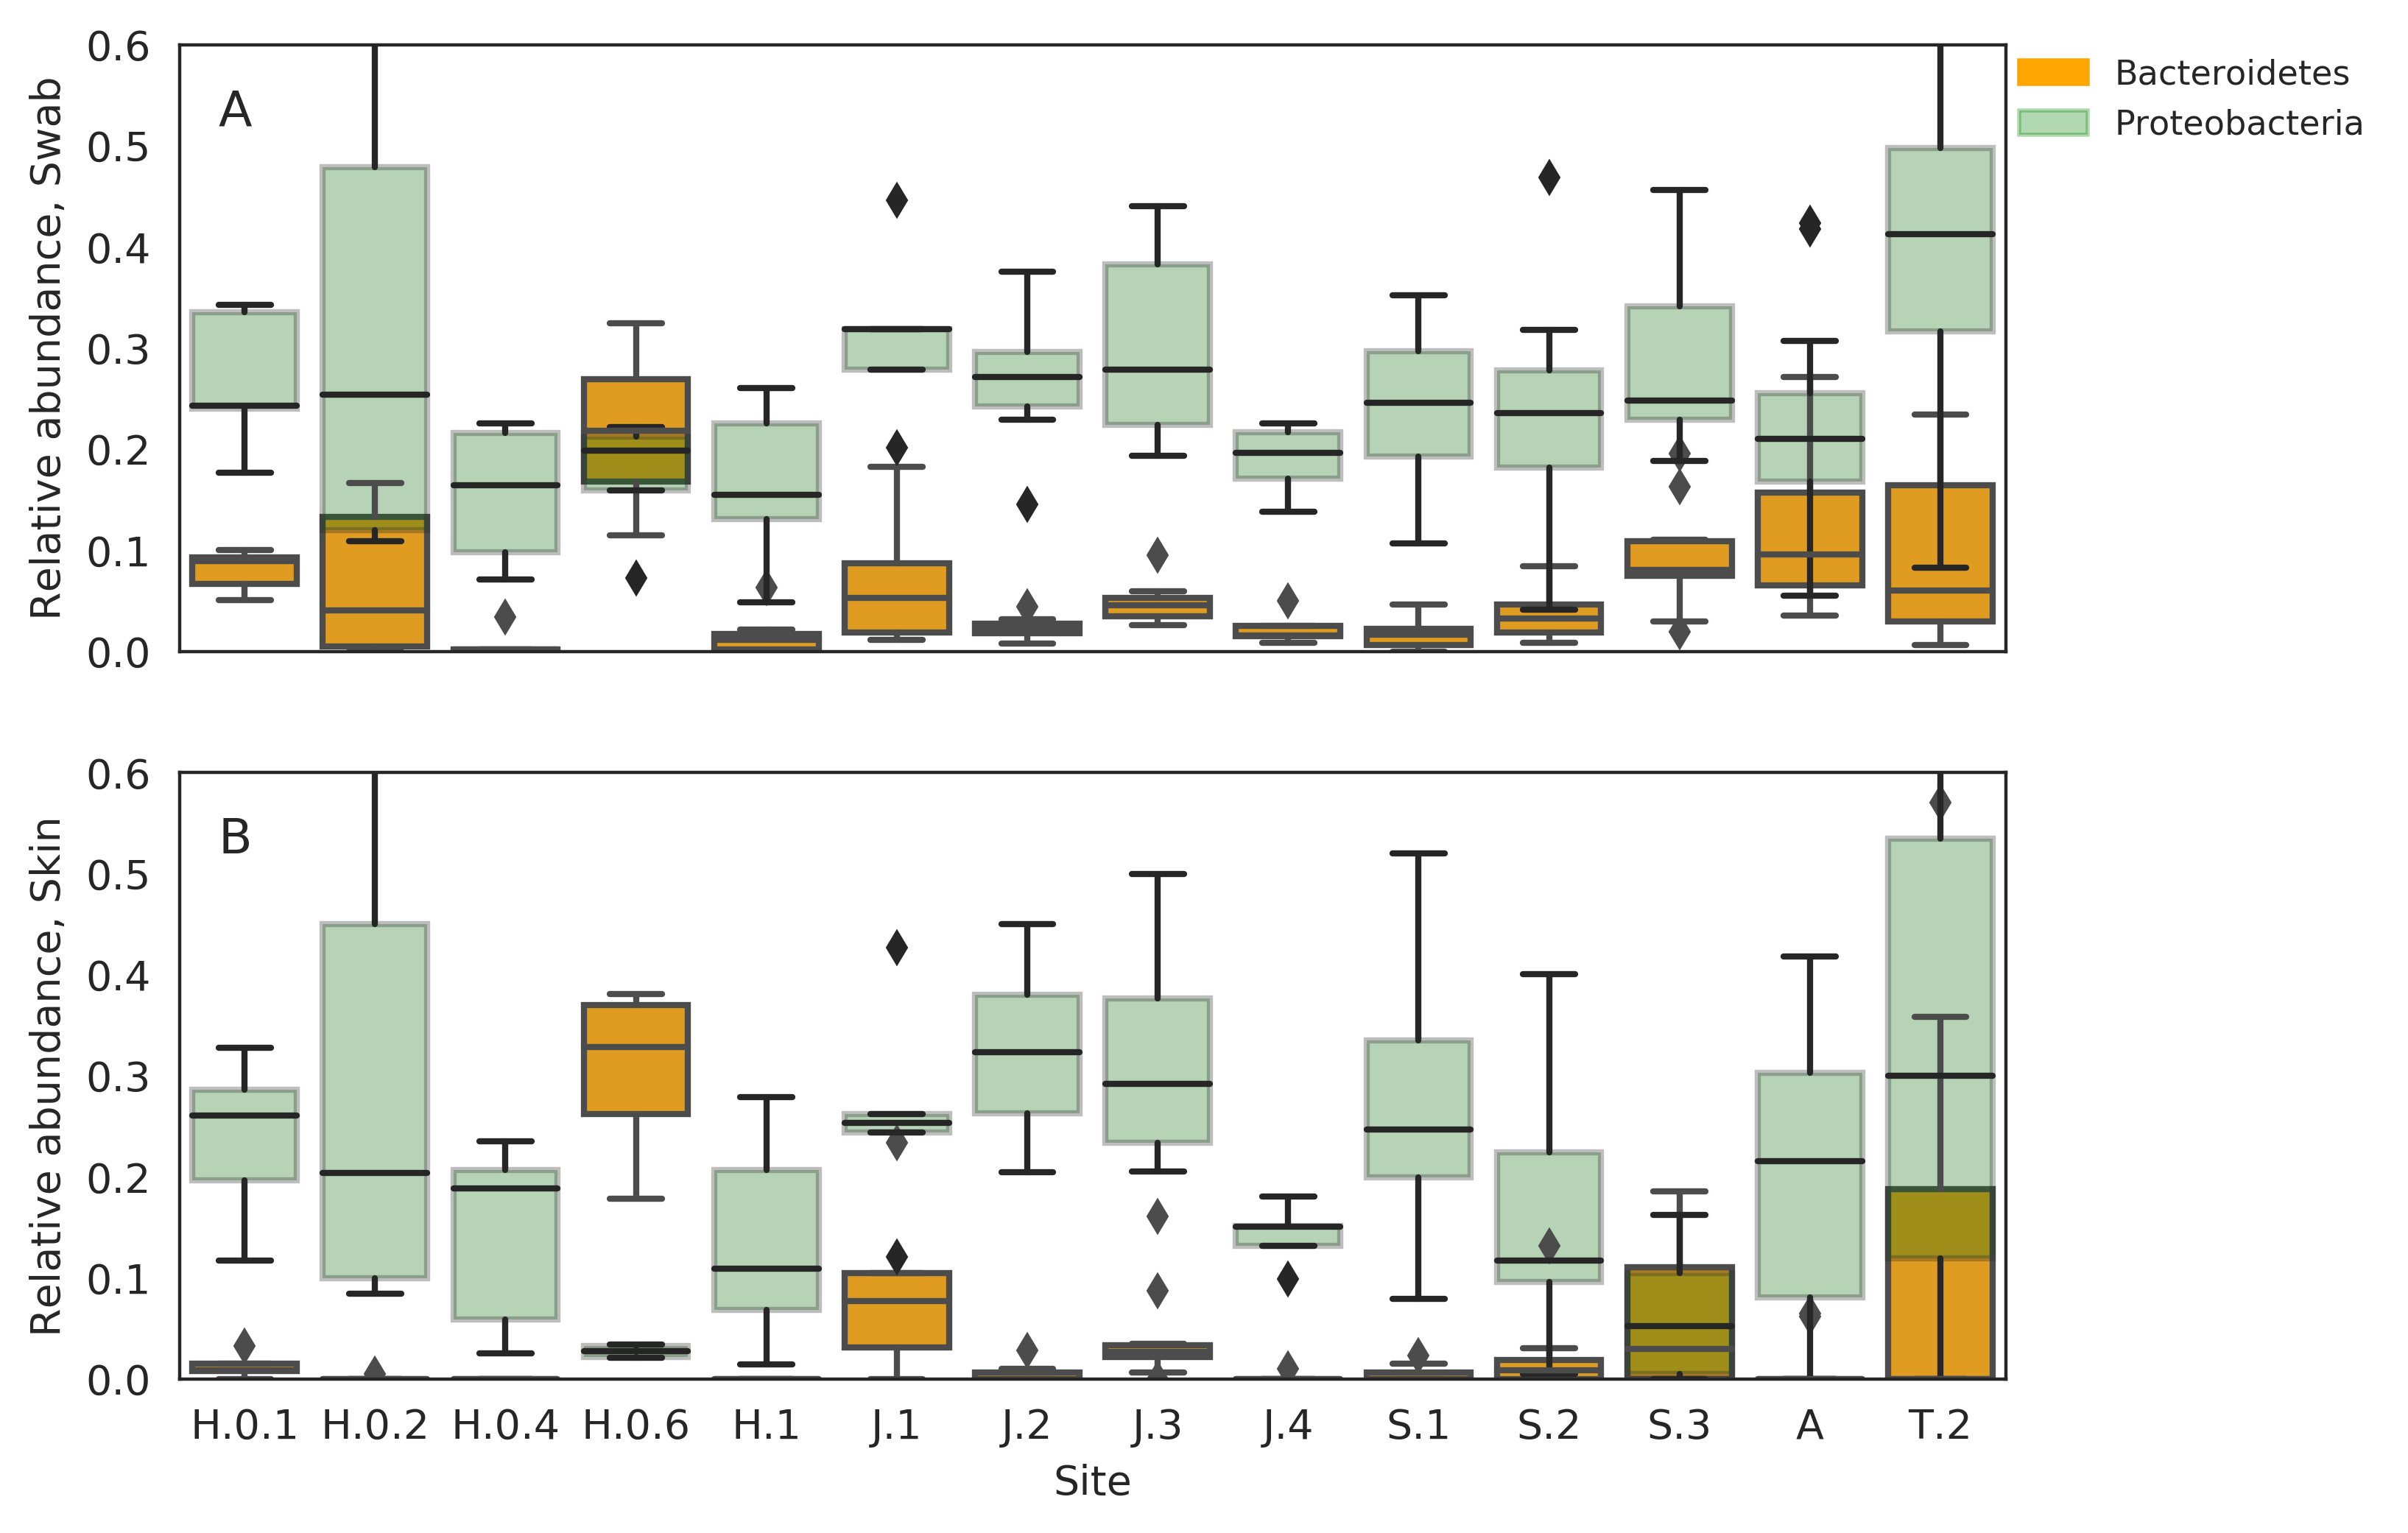

In [84]:
qza = 'denoised_tables/skin_table.3.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/feature-table.biom'
outf = 'temp.%s' % digest
a = !biom convert -i $inf -o $outf --to-tsv
skin = pd.read_csv(outf,skiprows=1,index_col=0,sep='\t')
!rm -r $digest
!rm $outf

qza = 'denoised_tables/swab_table.3.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/feature-table.biom'
outf = 'temp.%s' % digest
a = !biom convert -i $inf -o $outf --to-tsv
swab = pd.read_csv(outf,skiprows=1,index_col=0,sep='\t')
!rm -r $digest
!rm $outf

metadata = pd.read_csv('fish_samples_metadata_loc_code_correct_sp.tsv',index_col=0,sep='\t')

def get_phylum(ind):
    return ind.split(';')[1]

skin['phylum'] = skin.index.map(get_phylum)
swab['phylum'] = swab.index.map(get_phylum)

swab_bacteroides = swab.loc[swab.phylum == 'Bacteroidetes'].sum().drop('phylum')
swab_proteobacteria = swab.loc[swab.phylum == 'Proteobacteria'].sum().drop('phylum')

skin_bacteroides = skin.loc[skin.phylum == 'Bacteroidetes'].sum().drop('phylum')
skin_proteobacteria = skin.loc[skin.phylum == 'Proteobacteria'].sum().drop('phylum')

pb_swab= pd.DataFrame(columns = ['Site','SP','Stream', 'Basin','Proteobacteria', 'Bacteroidetes'])

for smpl in swab:
    if smpl =='phylum':
        continue
    if metadata.at[smpl,'Sampling site'] == 'T.1':
        continue
    pb_swab.loc[smpl] = [metadata.at[smpl,'Sampling site'], 
                         metadata.at[smpl,'SP'],
                         metadata.at[smpl,'Stream'],
                         metadata.at[smpl,'Basin'],
                         swab_proteobacteria[smpl] / swab.sum()[smpl], 
                         swab_bacteroides[smpl] / swab.sum()[smpl]]
    
pb_skin= pd.DataFrame(columns = ['Site','SP','Stream', 'Basin','Proteobacteria', 'Bacteroidetes'])

for smpl in skin:
    if smpl =='phylum':
        continue
    if metadata.at[smpl,'Sampling site'] == 'T.1':
        continue
    pb_skin.loc[smpl] = [metadata.at[smpl,'Sampling site'], 
                         metadata.at[smpl,'SP'],
                         metadata.at[smpl,'Stream'],
                         metadata.at[smpl,'Basin'],
                         skin_proteobacteria[smpl] / skin.sum()[smpl], 
                         skin_bacteroides[smpl] / skin.sum()[smpl]]
    
fig, axes = plt.subplots(nrows=2,dpi=400,figsize=(8,6))

ax = axes[0]
sns.boxplot(x='Site',y='Bacteroidetes',data=pb_swab.sort_values(['Basin','Stream','Site']),ax=ax,color='orange')
sns.boxplot(x='Site',y='Proteobacteria',data=pb_swab.sort_values(['Basin','Stream','Site']),ax=ax,color='green',boxprops=dict(alpha=.3))
ax.set_ylim((0,0.6))
ax.set_ylabel('Relative abundance, Swab')
ax.set_xlabel('')
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,fontsize='xx-small',frameon=False) 
ax.text(-0.2,0.52,'A',fontdict={'fontsize': 12})
ax.set_xticklabels([])

handles, labels = ([],[])

alphas = [1.0,0.3]
for color in ['orange','green']:
    handles += [mpatches.Patch([0.5,0.5],0.25,color=color,alpha=alphas.pop(0))]
labels += ['Bacteroidetes','Proteobacteria']

ax.legend(handles, 
          labels,
          bbox_to_anchor=(1, 1),
          loc=2, 
          borderaxespad=0.,
          fontsize='small',
          frameon=False) 

ax = axes[1]
sns.boxplot(x='Site',y='Bacteroidetes',data=pb_skin.sort_values(['Basin','Stream','Site']),ax=ax,color='orange')
sns.boxplot(x='Site',y='Proteobacteria',data=pb_skin.sort_values(['Basin','Stream','Site']),ax=ax,color='green',boxprops=dict(alpha=.3))
ax.set_ylim((0,0.6))
ax.set_ylabel('Relative abundance, Skin')
ax.legend().remove()  
ax.text(-0.2,0.52,'B',fontdict={'fontsize': 12})

fig.savefig('Figures/PB.png',bbox_inches='tight')

## PiCRUST, Skin VS Swab

In [ ]:
#!conda create -y -n picrust2 -c bioconda -c conda-forge picrust2

!mkdir -p picrust

# ASV sequences
qza = 'dada-rep-seqs.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/dna-sequences.fasta'
repseqs = SeqIO.to_dict(SeqIO.parse(inf,'fasta'))
!rm -r $digest 

#get skin-char biom
qza = 'skin_microbiome.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/feature-table.biom'
a = !cp $inf picrust/skin_char.biom

# get skin-char fasta
outf = 'temp.%s' % digest
a = !biom convert -i $inf -o $outf --to-tsv
biom = pd.read_table(outf,skiprows=1,index_col=0)
with open('picrust/skin_char.fasta','wt') as hndl:
    for ind in biom.index:
        hndl.write(repseqs[ind].format('fasta'))

!rm -r $digest
!rm $outf

#get swab biom
qza = 'core_taxa/skin_all_table.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/feature-table.biom'
a = !cp $inf picrust/swab.biom

# get swab fasta
outf = 'temp.%s' % digest
a = !biom convert -i $inf -o $outf --to-tsv
biom = pd.read_table(outf,skiprows=1,index_col=0)
with open('picrust/swab.fasta','wt') as hndl:
    for ind in biom.index:
        hndl.write(repseqs[ind].format('fasta'))

!rm -r $digest
!rm $outf

In [ ]:
%%bash

source activate picrust2 

picrust2_pipeline.py -s picrust/skin_char.fasta -i picrust/skin_char.biom -o picrust/skin_char_outputs -p 10
picrust2_pipeline.py -s picrust/swab.fasta -i picrust/swab.biom -o picrust/swab_outputs -p 10

add_descriptions.py -i picrust/swab_outputs/EC_metagenome_out/pred_metagenome_unstrat.tsv.gz -m EC \
                    -o picrust/swab_outputs/EC_metagenome_out/pred_metagenome_unstrat_descrip.tsv.gz

add_descriptions.py -i picrust/swab_outputs/pathways_out/path_abun_unstrat.tsv.gz -m METACYC \
                    -o picrust/swab_outputs/pathways_out/path_abun_unstrat_descrip.tsv.gz

add_descriptions.py -i picrust/skin_char_outputs/EC_metagenome_out/pred_metagenome_unstrat.tsv.gz -m EC \
                    -o picrust/skin_char_outputs/EC_metagenome_out/pred_metagenome_unstrat_descrip.tsv.gz

add_descriptions.py -i picrust/skin_char_outputs/pathways_out/path_abun_unstrat.tsv.gz -m METACYC \
                    -o picrust/skin_char_outputs/pathways_out/path_abun_unstrat_descrip.tsv.gz

In [ ]:
path_skin = pd.read_table('picrust/skin_char_outputs/EC_metagenome_out/pred_metagenome_unstrat_descrip.tsv.gz',sep='\t',index_col=0)
path_skin_no_desc = pd.read_table('picrust/skin_char_outputs/EC_metagenome_out/pred_metagenome_unstrat.tsv.gz',sep='\t',index_col=0)

path_skin_no_desc = path_skin_no_desc.div(path_skin_no_desc.sum(axis=0), axis=1)
path_skin_no_desc['M'] = path_skin_no_desc.mean(axis=1)
path_skin_no_desc = path_skin_no_desc.sort_values('M',ascending=False)

path_swab = pd.read_table('picrust/swab_outputs/EC_metagenome_out/pred_metagenome_unstrat_descrip.tsv.gz',sep='\t',index_col=0)
path_swab_no_desc = pd.read_table('picrust/swab_outputs/EC_metagenome_out/pred_metagenome_unstrat.tsv.gz',sep='\t',index_col=0)

path_swab_no_desc = path_swab_no_desc.div(path_swab_no_desc.sum(axis=0), axis=1)
path_swab_no_desc['M'] = path_swab_no_desc.mean(axis=1)
path_swab_no_desc = path_swab_no_desc.sort_values('M',ascending=False)

columns = []
for i in path_swab.columns:
    if i == 'description':
        columns.append(i)
    else:
        columns.append(i+'_swab')
path_swab.columns = columns

columns = []
for i in path_skin.columns:
    if i == 'description':
        columns.append(i)
    else:
        columns.append(i+'_skin')
path_skin.columns = columns

with open('picrust/metadata.tsv','wt') as hndl:
    hndl.write('#SampleID\tGroup\n')
    for col in path_skin.columns:
        if col == 'description':
            continue
        hndl.write(col + '\tskin\n')
    for col in path_swab.columns:
        if col == 'description':
            continue
        hndl.write(col + '\tswab\n')
        
paths = path_swab

for ind, row in path_skin.iterrows():
    for col in path_skin:
        paths.at[ind,col] = row[col]
        
sums = paths.sum()  

for ind, row in paths.iterrows():
    for col in paths:
        if col == 'description':
            continue
        paths.at[ind,col] = paths.at[ind,col] / float(sums[col])
    
paths.fillna(0).to_csv('picrust/paths.tsv',sep='\t')   

wilc_results = pd.DataFrame(columns=['U','pvalue','MoreIn'])

samples = set([i.split('_')[0] for i in path_swab.columns]).intersection(set([i.split('_')[0] for i in path_skin.columns]))

for ind, row in paths.iterrows():
    skin_values = row[[i+'_skin' for i in samples]].fillna(0).tolist()[1:]
    swab_values = row[[i+'_swab' for i in samples]].fillna(0).tolist()[1:]
    morein = 'swab'
    if median(skin_values)> median(swab_values):
        morein = 'skin'
    wilc_results.loc[ind] = list(wilcoxon(skin_values,swab_values))+[morein]
wilc_results['qvalue'] = list(multipletests(wilc_results.pvalue, method='fdr_bh'))[1]

for ind, row in wilc_results.loc[wilc_results.qvalue <0.05].iterrows():
    request = REST.kegg_get(str(ind).lower())
    open("temp", "w").write(request.read())
    records = Enzyme.parse(open("temp"))
    pathways = set()
    try:
        for r in records:
            for p in r.pathway:
                pathways.add(p[2])
        wilc_results.at[ind,'Pathways'] = ';'.join(list(pathways))
    except:
        continue
        
wilc_results.to_csv('picrust/wilcoxon.tsv',sep='\t')

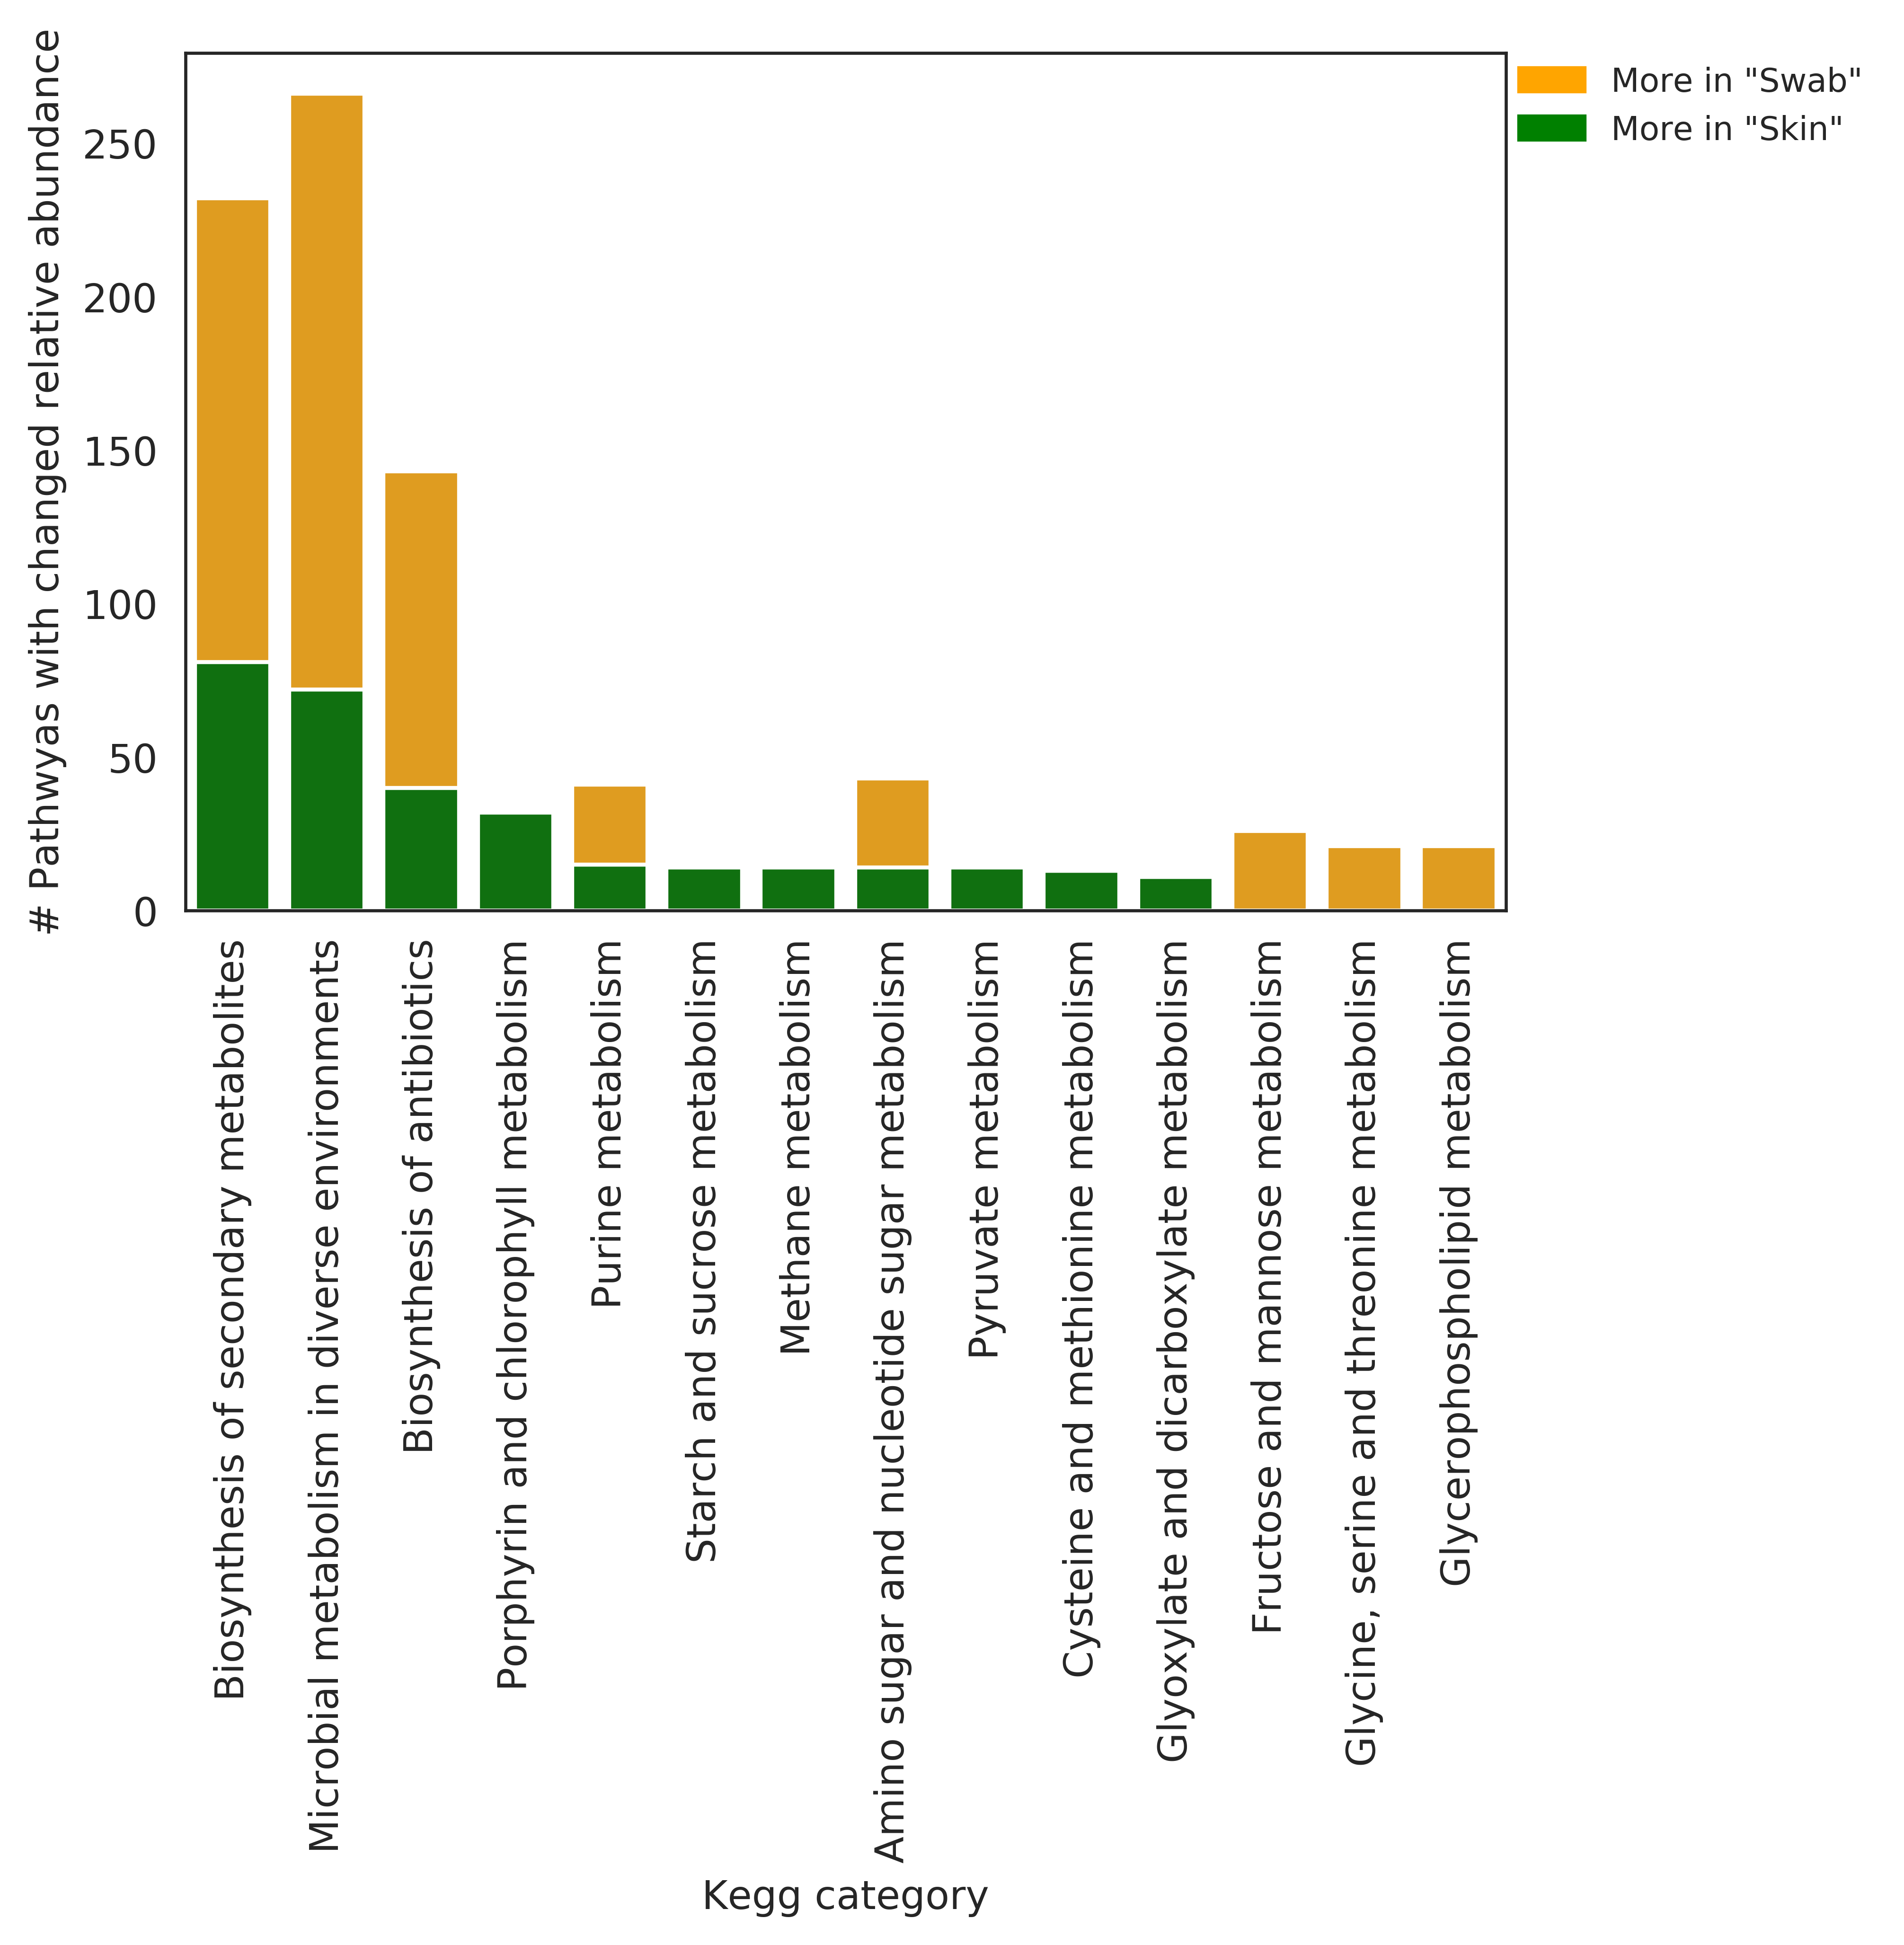

In [115]:
wilc_results = pd.read_csv('picrust/wilcoxon.tsv',sep='\t', index_col=0)


pathways = [i for i in wilc_results.loc[((wilc_results.MoreIn == 'skin') & (wilc_results.qvalue < 0.05))]['Pathways'].dropna().tolist() if len(i) > 0]
pathways = {i[0]: i[1] for i in sorted(Counter(list(chain(*[i.split(';') for i in pathways]))).items(), key=lambda x: x[1], reverse=True)}
pathways_summary = pd.DataFrame.from_dict(pathways, orient='index', columns=['Count'])
skin_pathways_summary = pathways_summary.loc[pathways_summary.Count > 10].sort_values('Count',ascending=False)

pathways = [i for i in wilc_results.loc[((wilc_results.MoreIn == 'swab') & (wilc_results.qvalue < 0.05))]['Pathways'].dropna().tolist() if len(i) > 0]
pathways = {i[0]: i[1] for i in sorted(Counter(list(chain(*[i.split(';') for i in pathways]))).items(), key=lambda x: x[1], reverse=True)}
pathways_summary = pd.DataFrame.from_dict(pathways, orient='index', columns=['Count'])
swab_pathways_summary = pathways_summary.loc[pathways_summary.Count > 19].sort_values('Count',ascending=False)

pathways_summary = pd.DataFrame()

for ind, row in skin_pathways_summary.iterrows():
    pathways_summary.at[ind,'Increase in Skin'] = row['Count']
for ind, row in swab_pathways_summary.iterrows():
    pathways_summary.at[ind,'Increase in Swab'] = row['Count']

pathways_summary = pathways_summary.fillna(0) 
pathways_summary['Group'] = pathways_summary.index
pathways_summary['Total'] = pathways_summary['Increase in Skin'] + pathways_summary['Increase in Swab']
pathways_summary = pathways_summary.loc[pathways_summary.Group != 'Metabolic pathways']

fig, ax = plt.subplots(dpi=600)

sns.barplot(x='Group',y='Increase in Skin',data=pathways_summary,color='green',ax=ax)
sns.barplot(x='Group',y='Increase in Swab',data=pathways_summary,color='orange',ax=ax,bottom=pathways_summary['Increase in Skin'])
a = ax.set_xticklabels([i.get_text() for i in ax.get_xticklabels()],rotation=90)
ax.set_xlabel('Kegg category')
ax.set_ylabel('# Pathwyas with changed relative abundance')

handles,labels = [],[]

for color in ['orange','green']:
    handles += [mpatches.Patch([0.5,0.5],0.25,color=color)]
labels += ['More in "Swab"','More in "Skin"']

ax.legend(handles, 
          labels,
          bbox_to_anchor=(1, 1),
          loc=2, 
          borderaxespad=0.,
          fontsize='small',
          frameon=False) 

fig.savefig('Figures/Kegg_pathways_change.png',bbox_inches='tight')

## Prepare NCBI metadat tables for BioSample and SRA archiving
#### Make BioSample metadata table

In [9]:
ncbi_columns = {'sample_title':'sample_title',
                '*organism':'*organism',
                'SP':'host',
                'type':'isolation_source',
                'Date':'*collection_date',
                'geo_loc_name':'*geo_loc_name',
                'lat_lon':'*lat_lon',
                'description':'description',
                'replicate':'replicate'}

samples_with_data = set([i.split('/')[-1].split('_')[0] for i in glob.glob('concat/AS*')])
biosample_metadata = metadata.loc[metadata.index.isin(samples_with_data)]
biosample_metadata = biosample_metadata.rename(ncbi_columns, axis='columns')
biosample_metadata.index.name = '*sample_name'

def get_geoloc(string):
    streams = {'H':'Hermon Stream','S': 'Snir Stream', 'J':'Jordan River, North of Sea of Galilee', 'T': 'Tel Saharonim', 'A': 'Asi Stream'}
    return 'Israel:'+streams[string]

biosample_metadata['*geo_loc_name'] = biosample_metadata.Stream.apply(get_geoloc)
biosample_metadata['*organism'] = 'Bacteria'
biosample_metadata['host'] = biosample_metadata.host.replace('Water', '')
biosample_metadata['host'] = biosample_metadata.host.replace('Tilapia zillii', 'Coptodon zillii')
biosample_metadata['host'] = biosample_metadata.host.replace('OH', 'Oreochromis')
biosample_metadata['host'] = biosample_metadata.host.replace('IH', 'Cichlidae')
biosample_metadata['isolation_source'] = biosample_metadata.isolation_source.replace('Swab', 'Fish skin swab')

def get_description(series):
    return "Metagenome sample of %s %s collected from %s" % (series['host'],series['isolation_source'],series['*geo_loc_name'])

biosample_metadata['description'] = biosample_metadata.apply(get_description,axis=1)
biosample_metadata['sample_title'] = biosample_metadata.apply(get_description,axis=1)


streams = set(biosample_metadata['*geo_loc_name'])
hosts = set(biosample_metadata['host'])
sites = set(biosample_metadata['Sampling site'])
replicate_counters = {}
for s in streams:
    replicate_counters[s] = {}
    for site in sites:
        replicate_counters[s][site] = {i:1 for i in hosts}

for ind, row in biosample_metadata.iterrows():
    if row['isolation_source'] == 'Water':
        continue
    counter = replicate_counters[row['*geo_loc_name']][row['Sampling site']][row['host']]
    replicate_counters[row['*geo_loc_name']][row['Sampling site']][row['host']] += 1
    biosample_metadata.at[ind,'replicate'] = 'biological replicate ' + str(counter)

biosample_metadata = biosample_metadata[list(ncbi_columns.values()) + ['Sampling site']]
biosample_metadata.to_csv('ncbi_biosample_metadata.tsv',sep='\t')

#### Make SRA metadata table

In [12]:
SRA_columns = ['library_ID','title','library_strategy','library_source',
               'library_selection','library_layout','platform','instrument_model',
               'design_description','filetype','filename','filename2']

sra_metadata = pd.DataFrame(columns = SRA_columns)
sra_metadata.index.name = 'sample_name'

for R1 in glob.glob('concat/AS*_R1_*.fastq'):
    smpl = R1.split('/')[-1].split('_')[0]
    replicate = biosample_metadata.at[smpl,'replicate']
    if isinstance(replicate,float):
        replicate = ''
    title = biosample_metadata.at[smpl,'description'].replace('Metagenome','16 rRNA V3V4 metabarcoding')+', '+replicate
    r1 = R1.split('/')[-1]+ '.gz'
    r2 = r1.replace('_R1_','_R2_')
    description = 'Single barcode, two-step PCR, V3-V4 fragment'
    sra_metadata.loc[smpl] = [smpl, title, 'AMPLICON','GENOMIC','PCR',
                              'paired','ILLUMINA','Illumina MiSeq',
                              description,'fastq',r1,r2]
sra_metadata.to_csv('ncbi_sra_metadata.tsv',sep='\t')